In [1]:
import os
import sys
import warnings

import pdb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import ExtraTreesRegressor

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import generate_and_avaliate_model

from utils import location_station, find_set_sunrise, find_set_sunset, to_datetime
from utils import plot_sunrise_and_sunset
from utils import smooth_signal



%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise_update1.pkl')
df_station = pd.read_pickle('./data/df_station_sort_re.pkl')

In [3]:
df.head()

vtec   vtec_dt  vtec_dt2    gvtec1  gvtec1_dt  \
2013-12-01 02:10:00  38.901869 -1.406371  0.090805 -3.012794  -0.302865   
2013-12-01 02:20:00  37.676039 -1.201542  0.204829 -3.176458  -0.149123   
2013-12-01 02:30:00  36.751092 -0.957067  0.244475 -3.090844   0.030793   
2013-12-01 02:40:00  36.059834 -0.762969  0.194098 -2.880283   0.127728   
2013-12-01 02:50:00  35.416633 -0.653073  0.109896 -2.733366   0.097938   

                       gvtec2  gvtec2_dt    gvtec3  gvtec3_dt        s4  \
2013-12-01 02:10:00 -0.138129  -2.709478 -0.748023  -0.046265  0.116034   
2013-12-01 02:20:00 -1.840996  -1.712064 -0.797389  -0.046810  0.112015   
2013-12-01 02:30:00 -2.211419  -0.669840 -0.815543  -0.040540  0.111552   
2013-12-01 02:40:00 -1.957485  -0.038873 -0.858718  -0.060494  0.108269   
2013-12-01 02:50:00 -1.737745   0.141762 -0.969081  -0.102394  0.106616   

                         ...        state_night  state_dawn  state_day_shift  \
2013-12-01 02:10:00      ...                0.0         1.0              NaN   
2013-12-01 02:20:00      ...                0.0         1.0              0.0   
2013-12-01 02:30:00      ...                0.0         1.0              0.0   
2013-12-01 02:40:00      ...                0.0         1.0              0.0   
2013-12-01 02:50:00      ...                0.0         1.0              0.0   

                     vm1  vd1  vm2  vd2  gvtec1_dt_lag_9  gvtec2_dt_lag_20  \
2013-12-01 02:10:00  NaN  NaN  NaN  NaN              NaN               NaN   
2013-12-01 02:20:00  NaN  NaN  NaN  NaN              NaN               NaN   
2013-12-01 02:30:00  NaN  NaN  NaN  NaN              NaN               NaN   
2013-12-01 02:40:00  NaN  NaN  NaN  NaN              NaN               NaN   
2013-12-01 02:50:00  NaN  NaN  NaN  NaN              NaN               NaN   

                     vtec_dt_lag_3  
2013-12-01 02:10:00            NaN  
2013-12-01 02:20:00            NaN  
2013-12-01 02:30:00            NaN  
2013-12-01 02:40:00      -2.842035  
2013-12-01 02:50:00      -2.259406  

[5 rows x 21 columns]

In [4]:
df_vtec = pd.DataFrame(index=df.index.values)

In [5]:
for i in range(0, 24):
    df_vtec['lag_'+str(i)] = df['vtec'].shift(i)
    
df_vtec['s4'] = df['s4']

df_vtec.to_pickle('./data/df_vtec_lags.pkl')

df.head()

vtec   vtec_dt  vtec_dt2    gvtec1  gvtec1_dt  \
2013-12-01 02:10:00  38.901869 -1.406371  0.090805 -3.012794  -0.302865   
2013-12-01 02:20:00  37.676039 -1.201542  0.204829 -3.176458  -0.149123   
2013-12-01 02:30:00  36.751092 -0.957067  0.244475 -3.090844   0.030793   
2013-12-01 02:40:00  36.059834 -0.762969  0.194098 -2.880283   0.127728   
2013-12-01 02:50:00  35.416633 -0.653073  0.109896 -2.733366   0.097938   

                       gvtec2  gvtec2_dt    gvtec3  gvtec3_dt        s4  \
2013-12-01 02:10:00 -0.138129  -2.709478 -0.748023  -0.046265  0.116034   
2013-12-01 02:20:00 -1.840996  -1.712064 -0.797389  -0.046810  0.112015   
2013-12-01 02:30:00 -2.211419  -0.669840 -0.815543  -0.040540  0.111552   
2013-12-01 02:40:00 -1.957485  -0.038873 -0.858718  -0.060494  0.108269   
2013-12-01 02:50:00 -1.737745   0.141762 -0.969081  -0.102394  0.106616   

                         ...        state_night  state_dawn  state_day_shift  \
2013-12-01 02:10:00      ...                0.0         1.0              NaN   
2013-12-01 02:20:00      ...                0.0         1.0              0.0   
2013-12-01 02:30:00      ...                0.0         1.0              0.0   
2013-12-01 02:40:00      ...                0.0         1.0              0.0   
2013-12-01 02:50:00      ...                0.0         1.0              0.0   

                     vm1  vd1  vm2  vd2  gvtec1_dt_lag_9  gvtec2_dt_lag_20  \
2013-12-01 02:10:00  NaN  NaN  NaN  NaN              NaN               NaN   
2013-12-01 02:20:00  NaN  NaN  NaN  NaN              NaN               NaN   
2013-12-01 02:30:00  NaN  NaN  NaN  NaN              NaN               NaN   
2013-12-01 02:40:00  NaN  NaN  NaN  NaN              NaN               NaN   
2013-12-01 02:50:00  NaN  NaN  NaN  NaN              NaN               NaN   

                     vtec_dt_lag_3  
2013-12-01 02:10:00            NaN  
2013-12-01 02:20:00            NaN  
2013-12-01 02:30:00            NaN  
2013-12-01 02:40:00      -2.842035  
2013-12-01 02:50:00      -2.259406  

[5 rows x 21 columns]

In [6]:
df['vtec_i/vtec_i-1'] = df_vtec['lag_0']/df_vtec['lag_1']

In [7]:
for i in range(3, 15, 2):
    df['roti_'+str(i)] = df['vtec_dt'].rolling(i, center=True).std()

In [8]:
df.head()

vtec   vtec_dt  vtec_dt2    gvtec1  gvtec1_dt  \
2013-12-01 02:10:00  38.901869 -1.406371  0.090805 -3.012794  -0.302865   
2013-12-01 02:20:00  37.676039 -1.201542  0.204829 -3.176458  -0.149123   
2013-12-01 02:30:00  36.751092 -0.957067  0.244475 -3.090844   0.030793   
2013-12-01 02:40:00  36.059834 -0.762969  0.194098 -2.880283   0.127728   
2013-12-01 02:50:00  35.416633 -0.653073  0.109896 -2.733366   0.097938   

                       gvtec2  gvtec2_dt    gvtec3  gvtec3_dt        s4  \
2013-12-01 02:10:00 -0.138129  -2.709478 -0.748023  -0.046265  0.116034   
2013-12-01 02:20:00 -1.840996  -1.712064 -0.797389  -0.046810  0.112015   
2013-12-01 02:30:00 -2.211419  -0.669840 -0.815543  -0.040540  0.111552   
2013-12-01 02:40:00 -1.957485  -0.038873 -0.858718  -0.060494  0.108269   
2013-12-01 02:50:00 -1.737745   0.141762 -0.969081  -0.102394  0.106616   

                      ...     gvtec1_dt_lag_9  gvtec2_dt_lag_20  \
2013-12-01 02:10:00   ...                 NaN               NaN   
2013-12-01 02:20:00   ...                 NaN               NaN   
2013-12-01 02:30:00   ...                 NaN               NaN   
2013-12-01 02:40:00   ...                 NaN               NaN   
2013-12-01 02:50:00   ...                 NaN               NaN   

                     vtec_dt_lag_3  vtec_i/vtec_i-1    roti_3    roti_5  \
2013-12-01 02:10:00            NaN              NaN       NaN       NaN   
2013-12-01 02:20:00            NaN         0.968489  0.224943       NaN   
2013-12-01 02:30:00            NaN         0.975450  0.219768  0.309867   
2013-12-01 02:40:00      -2.842035         0.981191  0.153929  0.252655   
2013-12-01 02:50:00      -2.259406         0.982163  0.094733  0.183303   

                       roti_7    roti_9  roti_11  roti_13  
2013-12-01 02:10:00       NaN       NaN      NaN      NaN  
2013-12-01 02:20:00       NaN       NaN      NaN      NaN  
2013-12-01 02:30:00       NaN       NaN      NaN      NaN  
2013-12-01 02:40:00  0.341797       NaN      NaN      NaN  
2013-12-01 02:50:00  0.280005  0.358923      NaN      NaN  

[5 rows x 28 columns]

In [9]:
df['gvtec1/gvtec2'] = df['gvtec1']/df['gvtec2']
df['gvtec1_dt/gvtec2_dt'] = df['gvtec1_dt']/df['gvtec2_dt']

In [10]:
df.to_pickle('./data/sj2_analise_update2.pkl')
df.to_csv('./data/sj2_analise_update2.csv')

In [11]:
list_day = []
list_second = []
for i in df.index.values:
    datetime_value = to_datetime(i)
    list_day.append(float(datetime_value.day))
    list_second.append(float(datetime_value.hour*3600+datetime_value.minute*60+datetime_value.second))

df['doy'] = list_day
df['ut'] = list_second

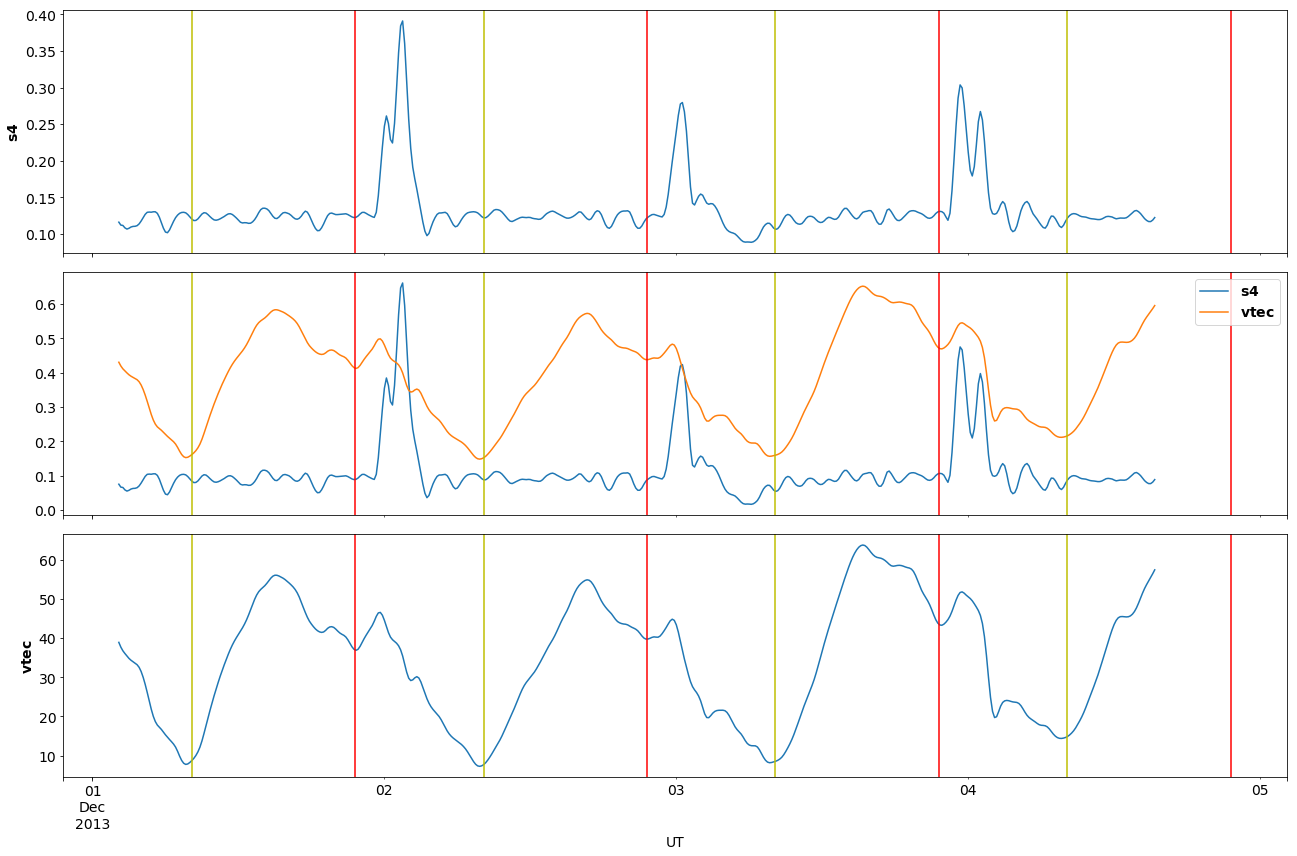

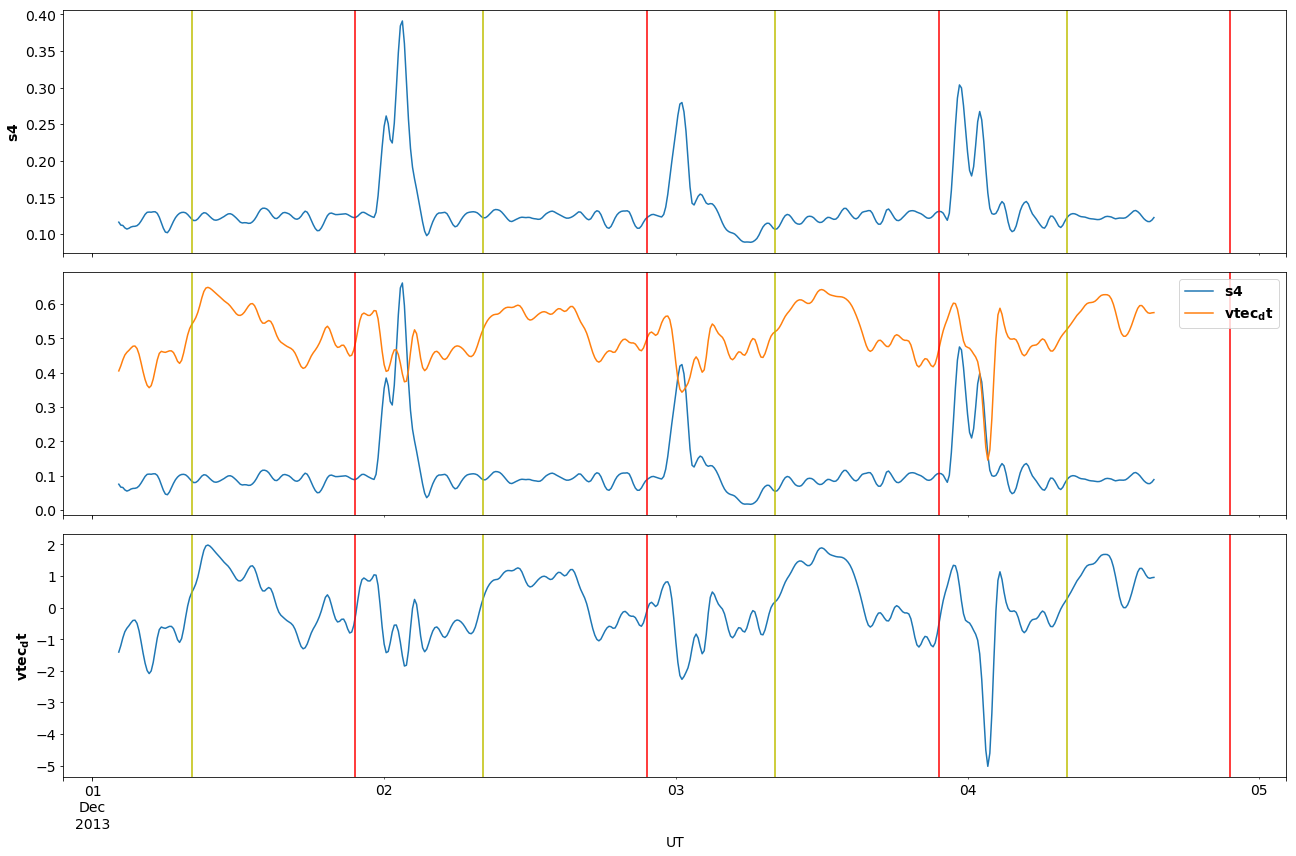

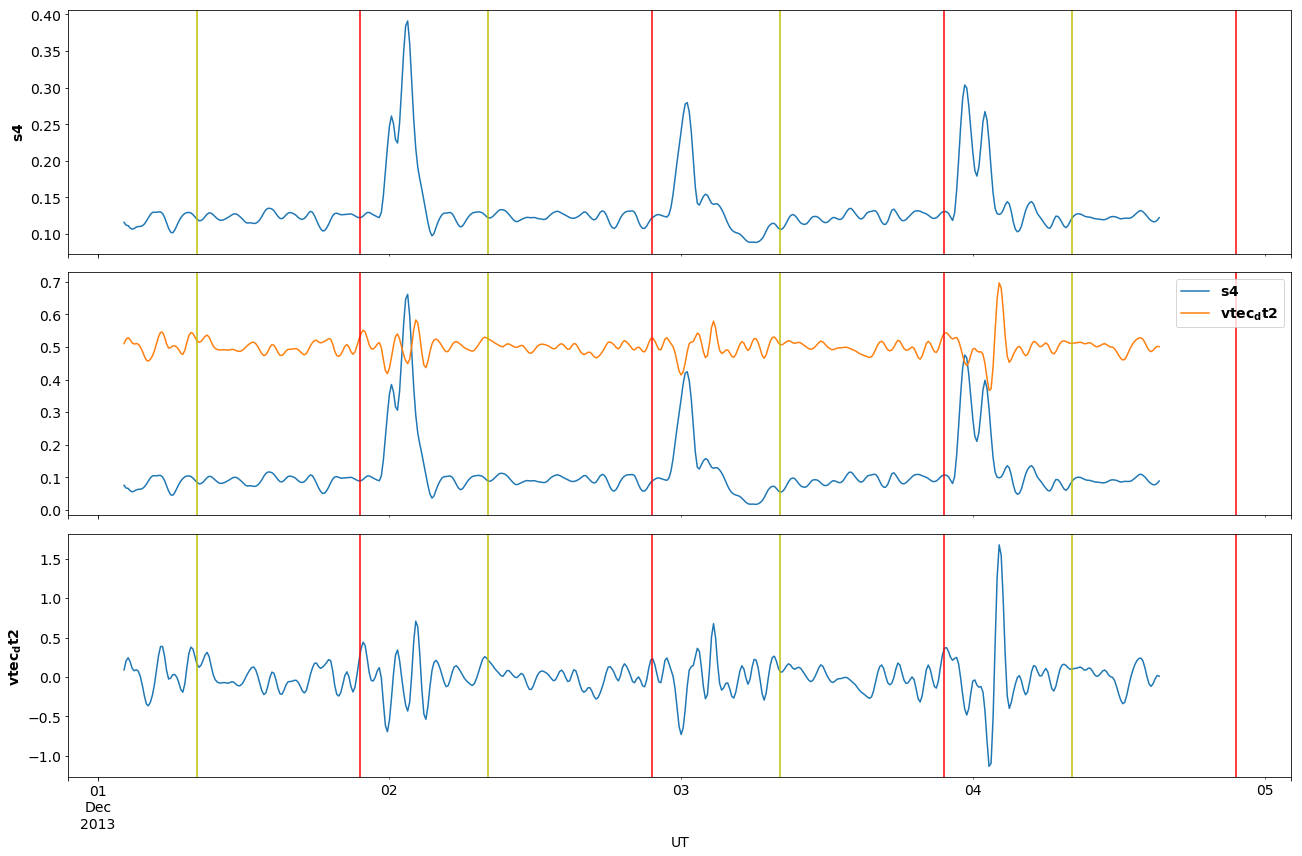

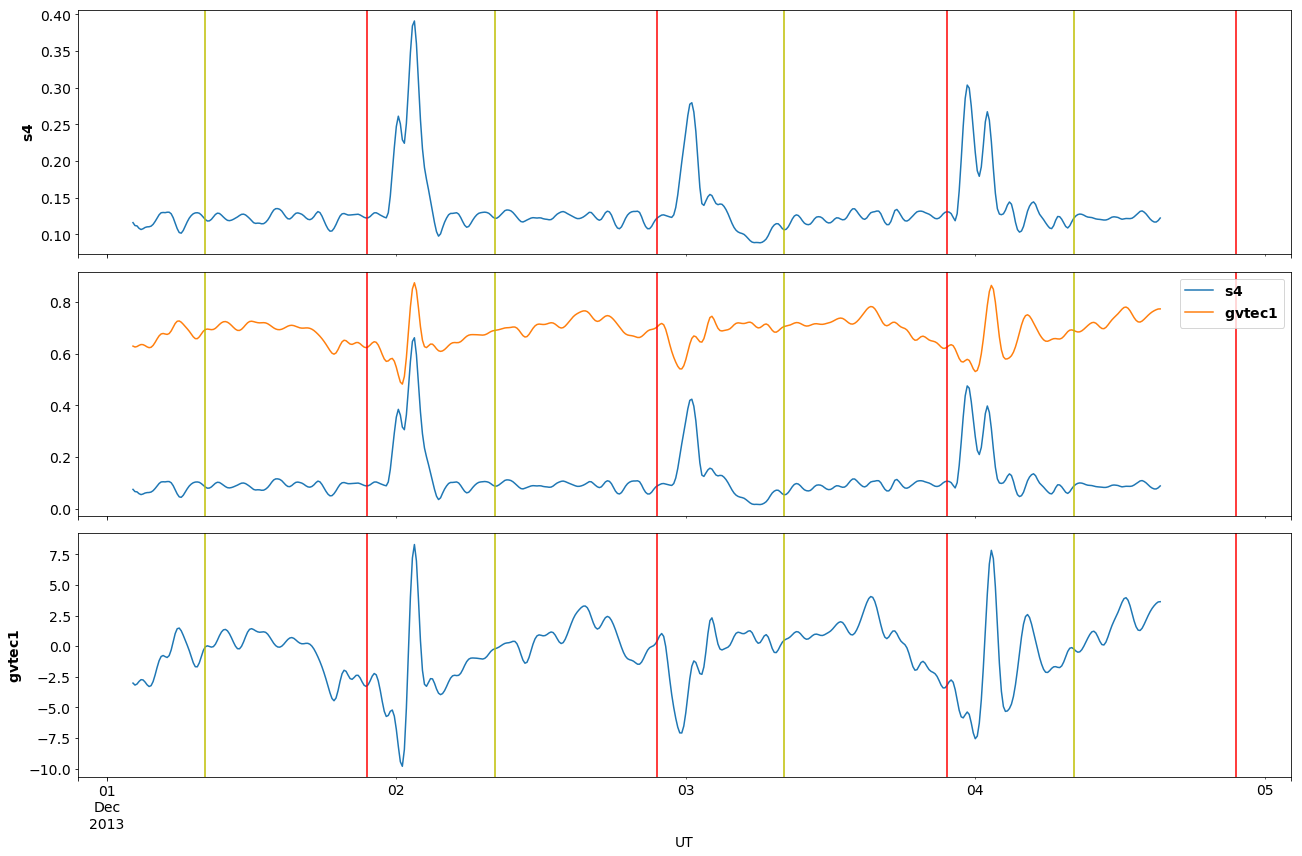

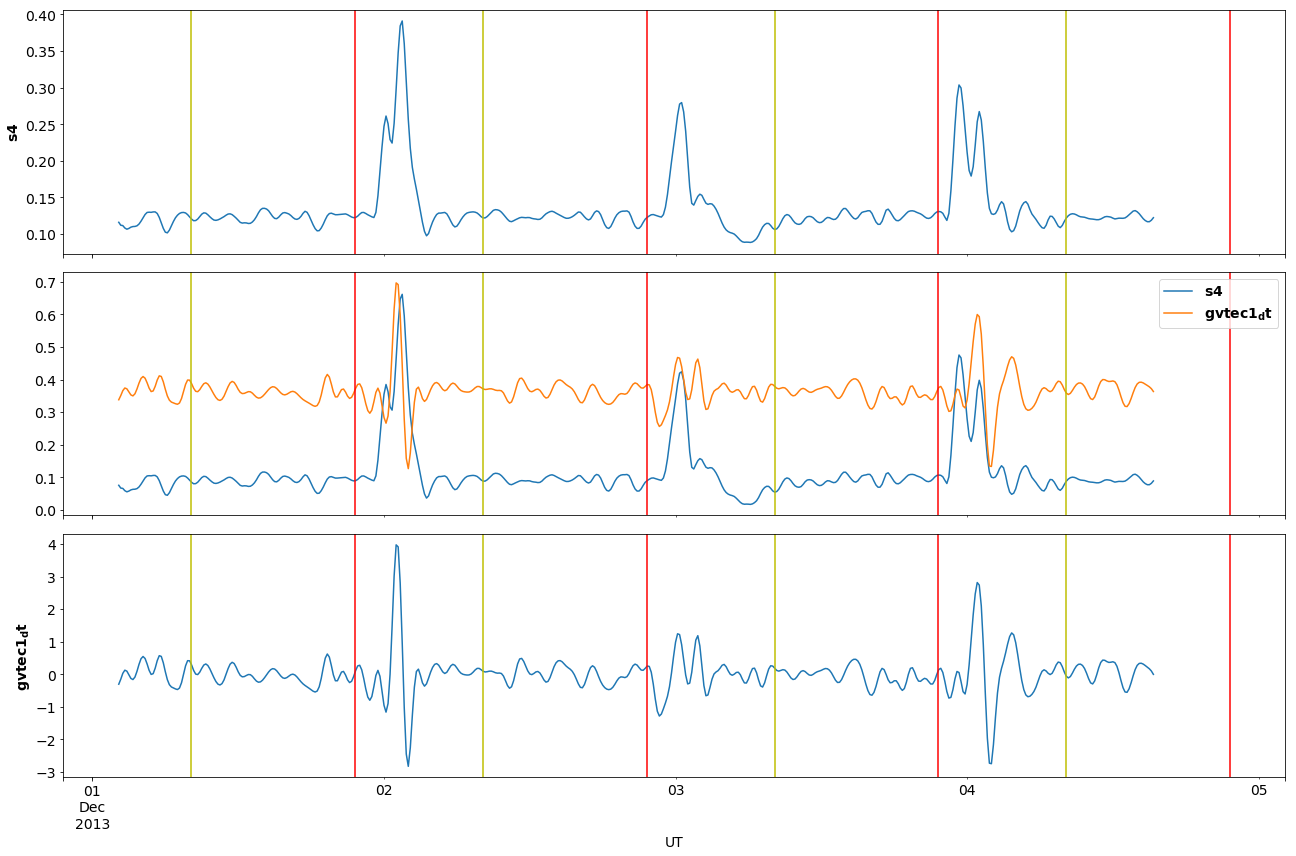

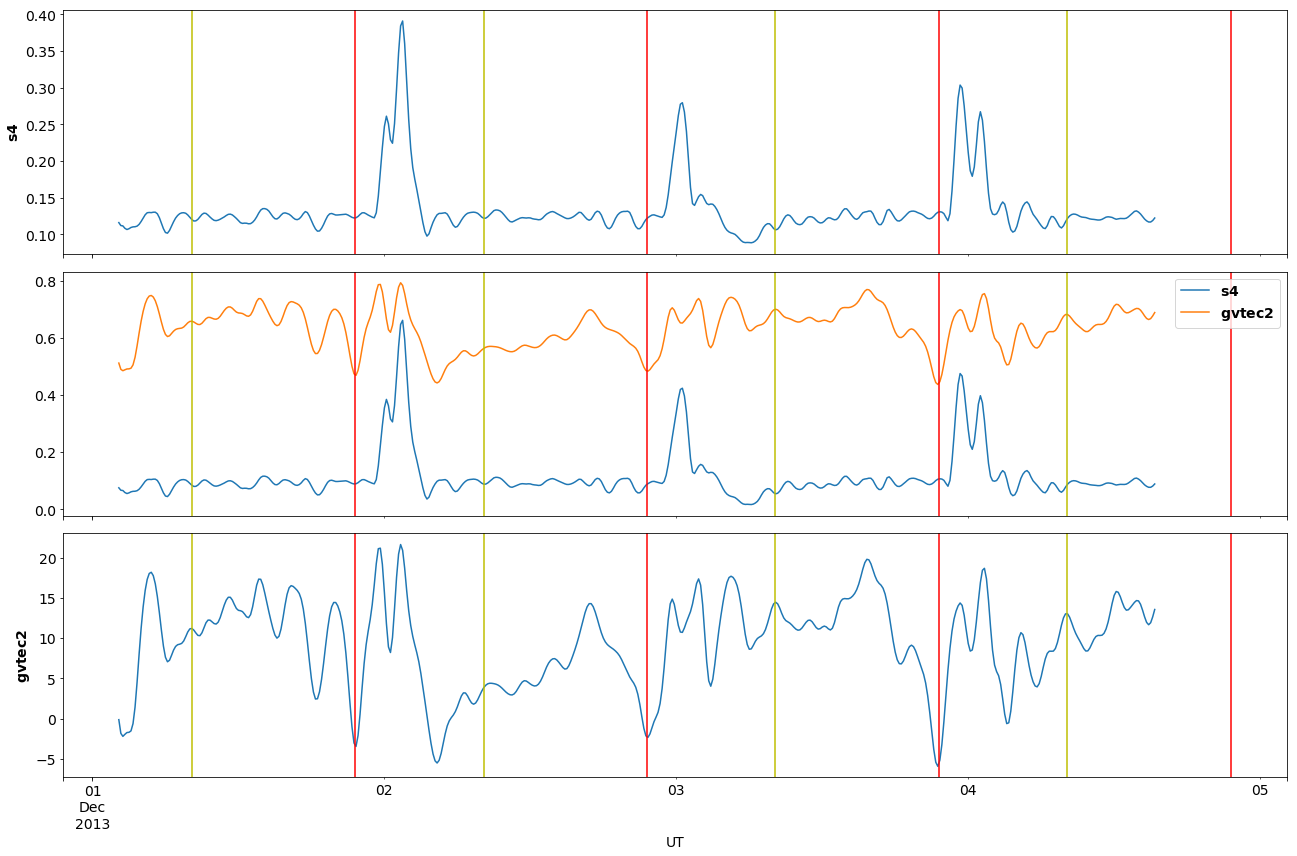

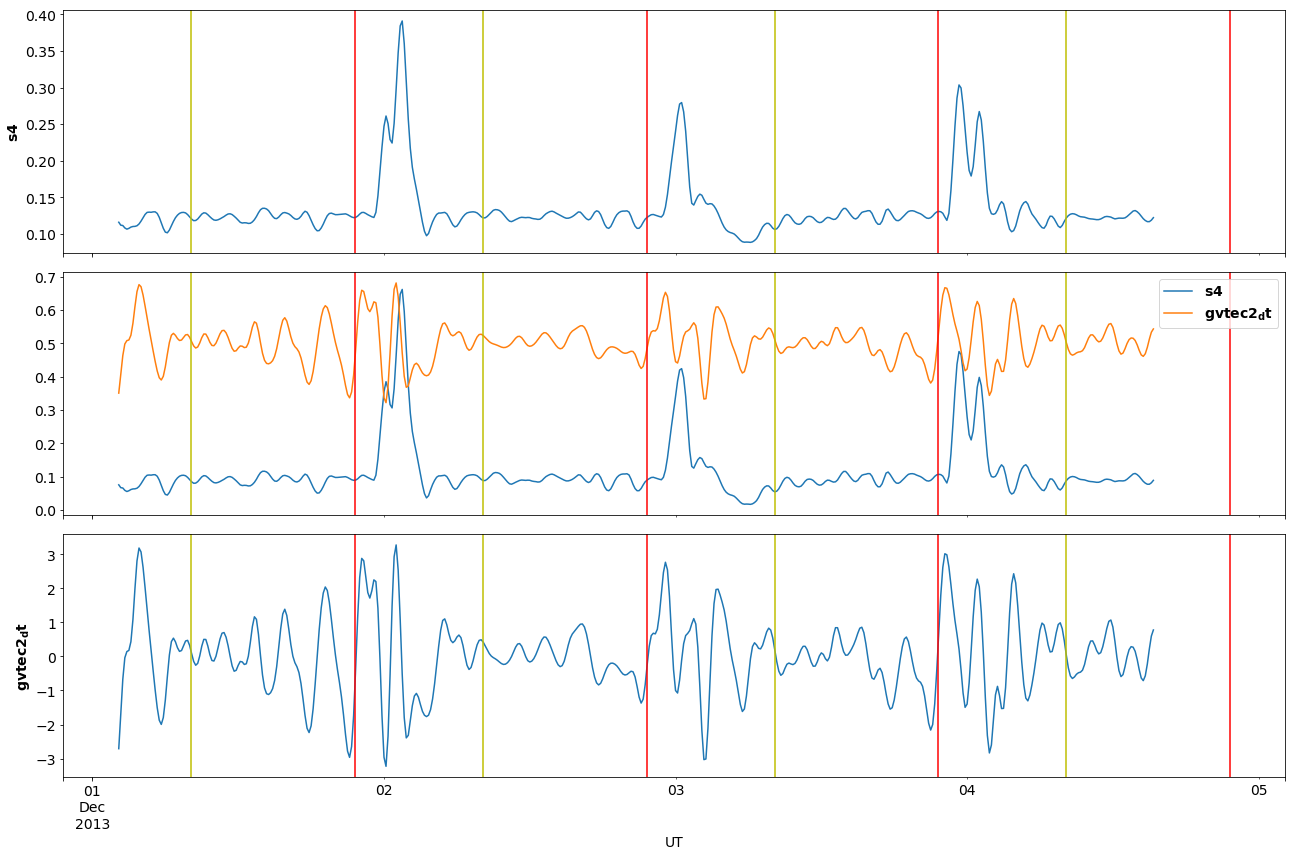

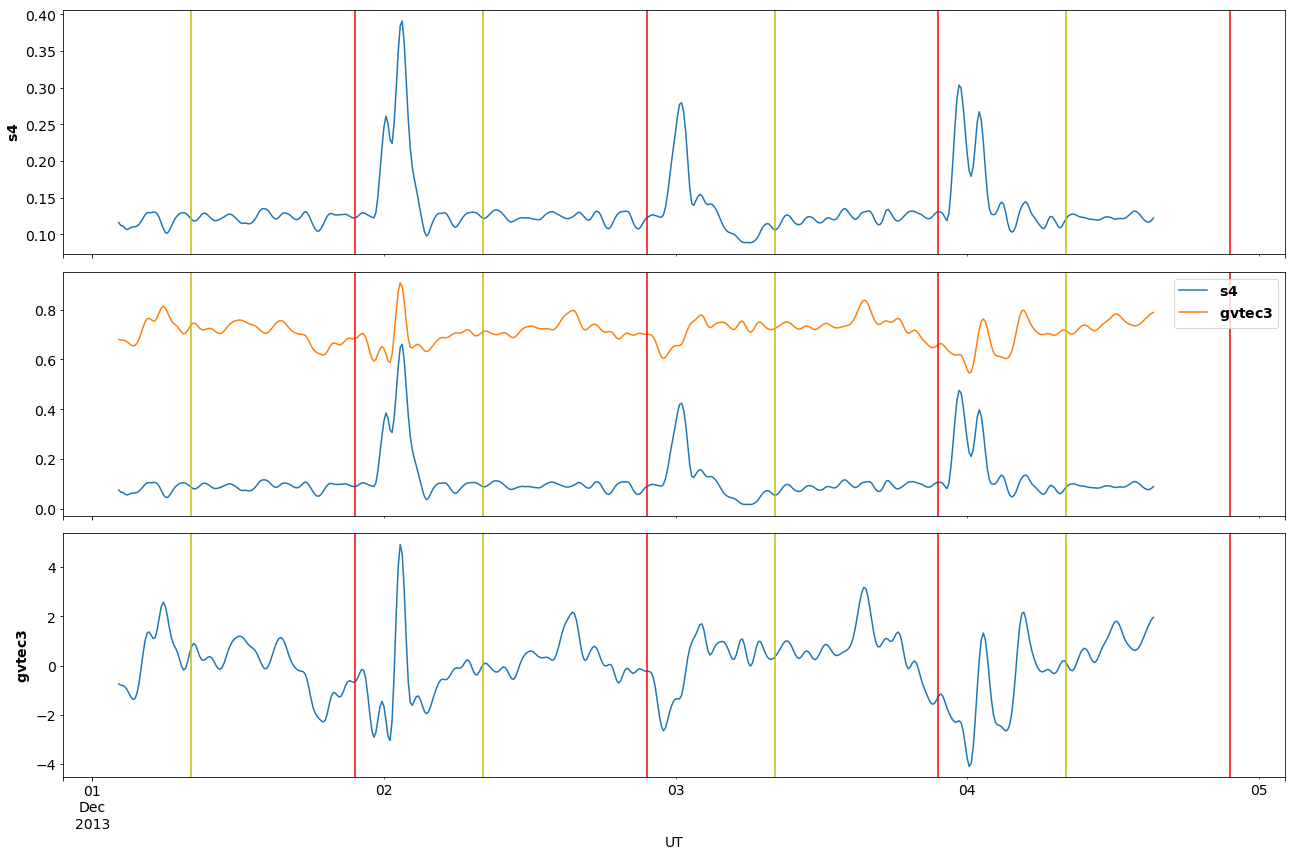

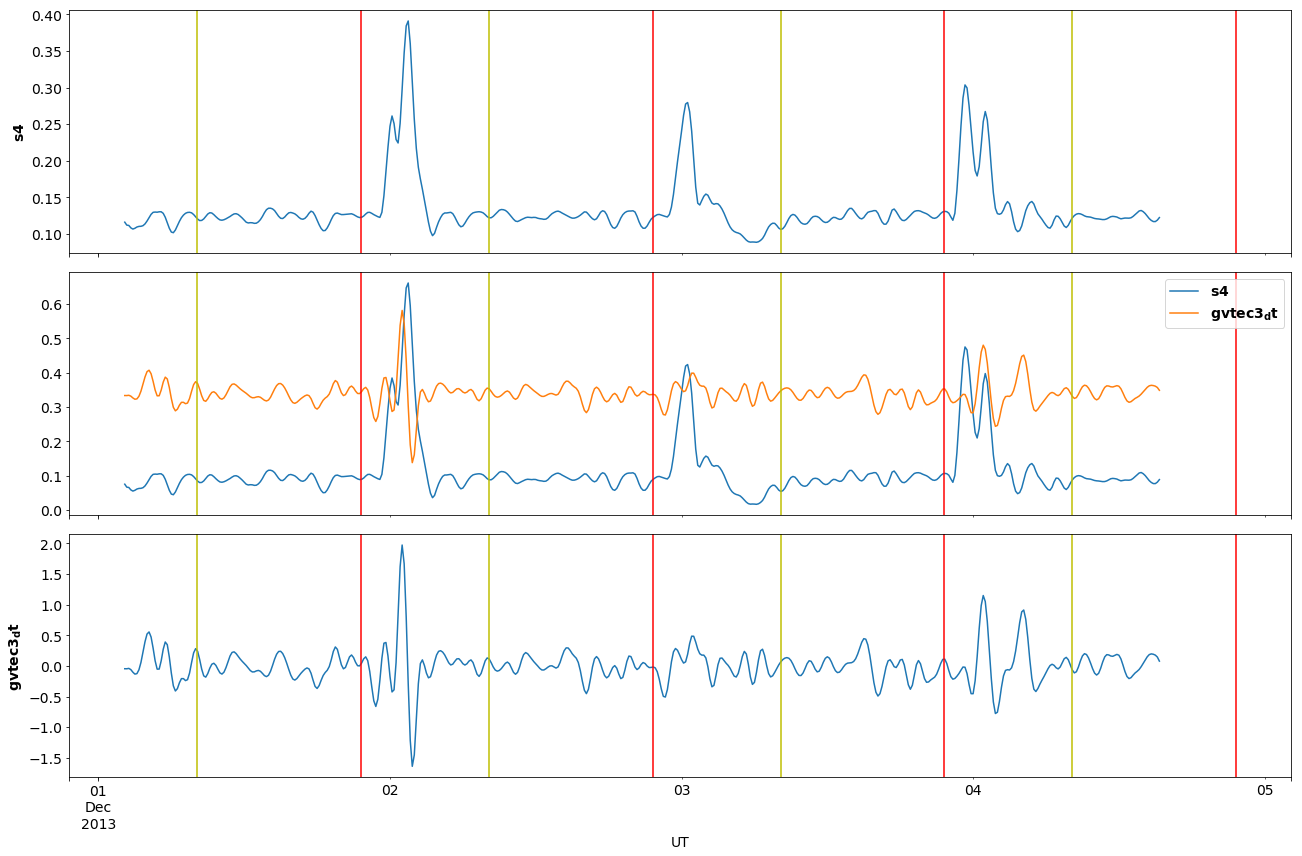

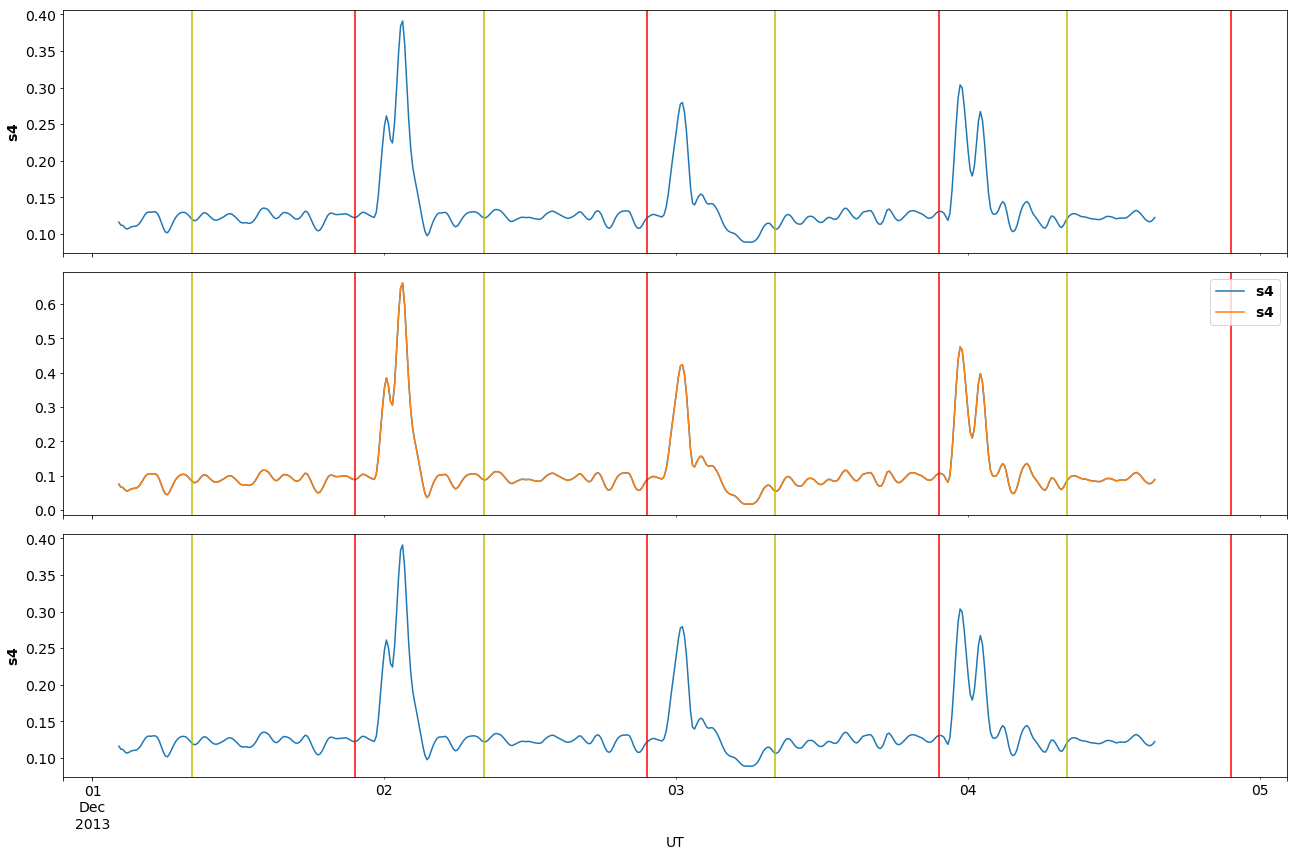

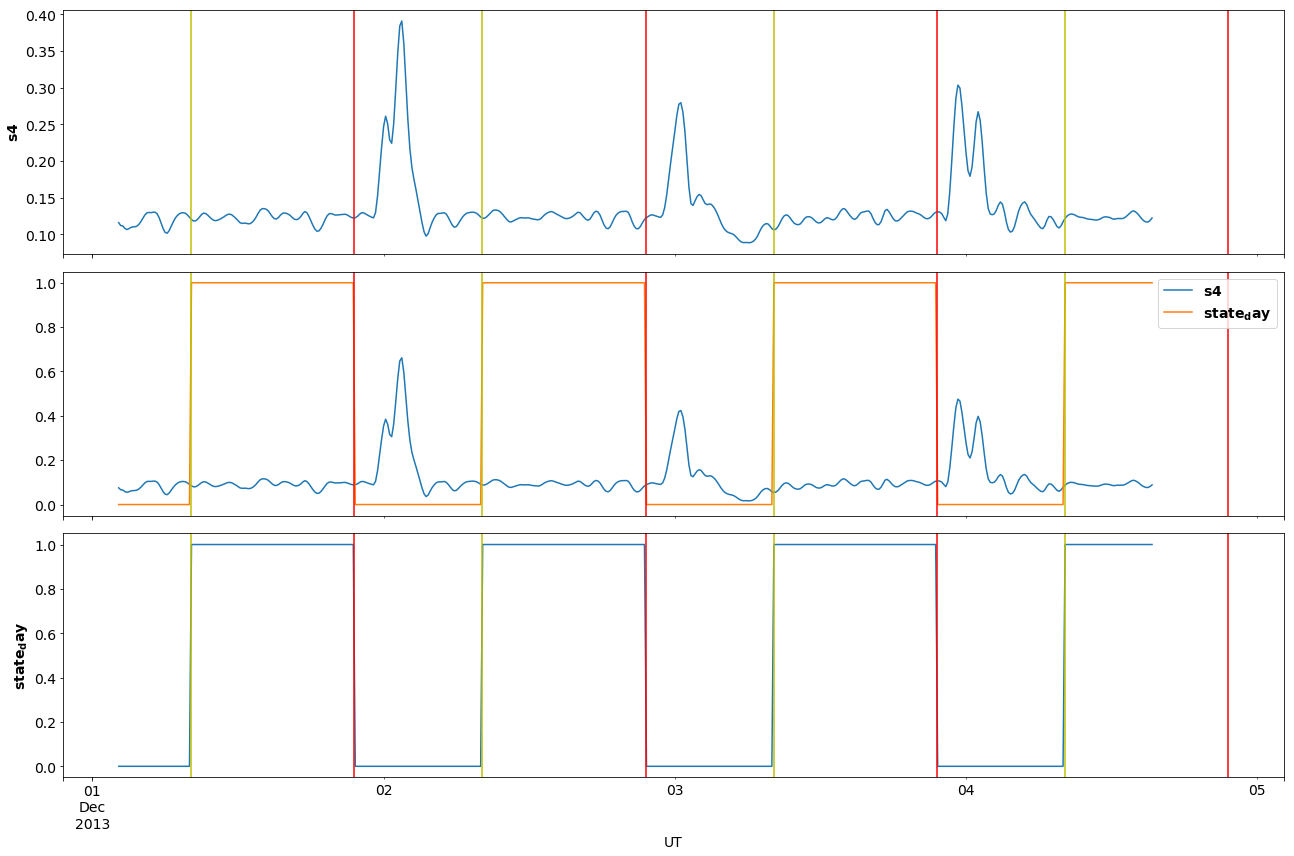

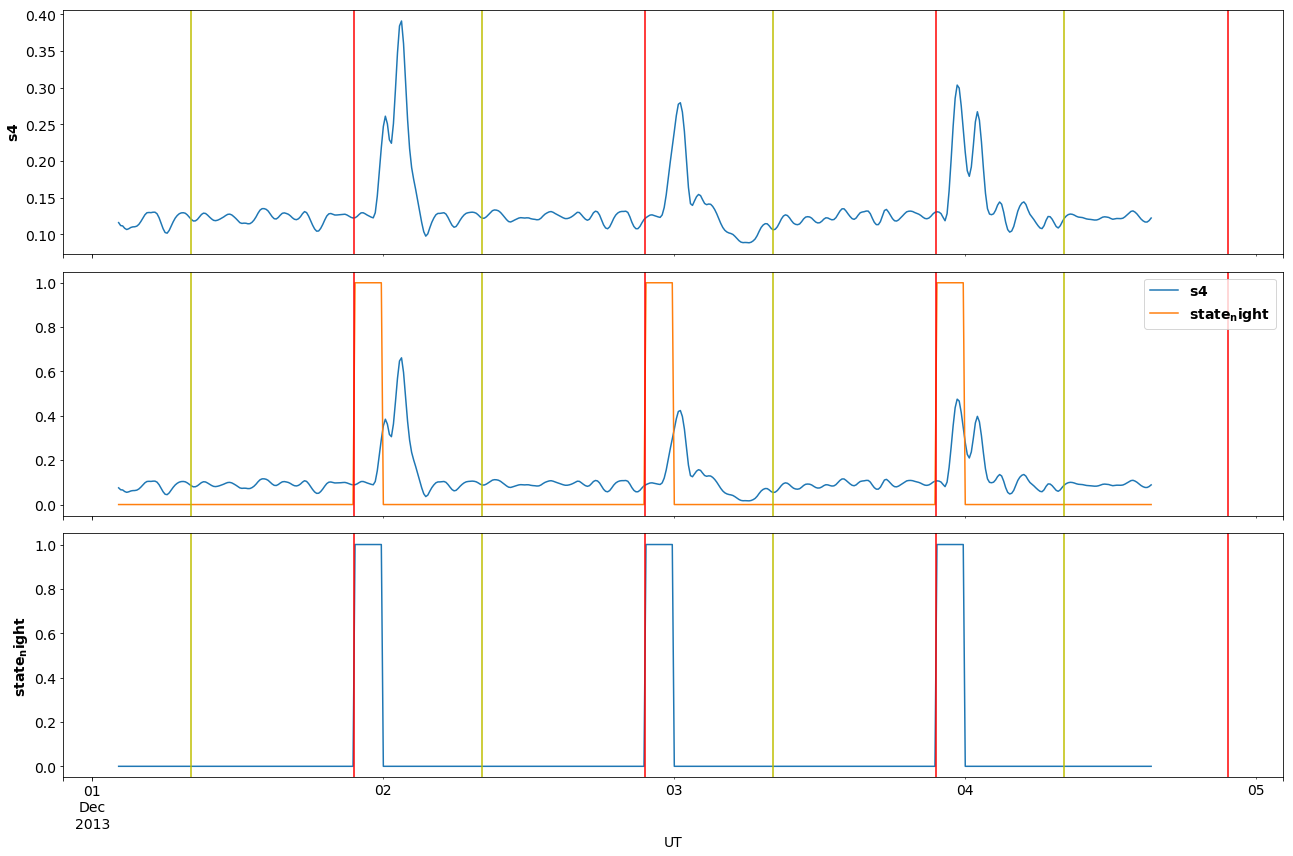

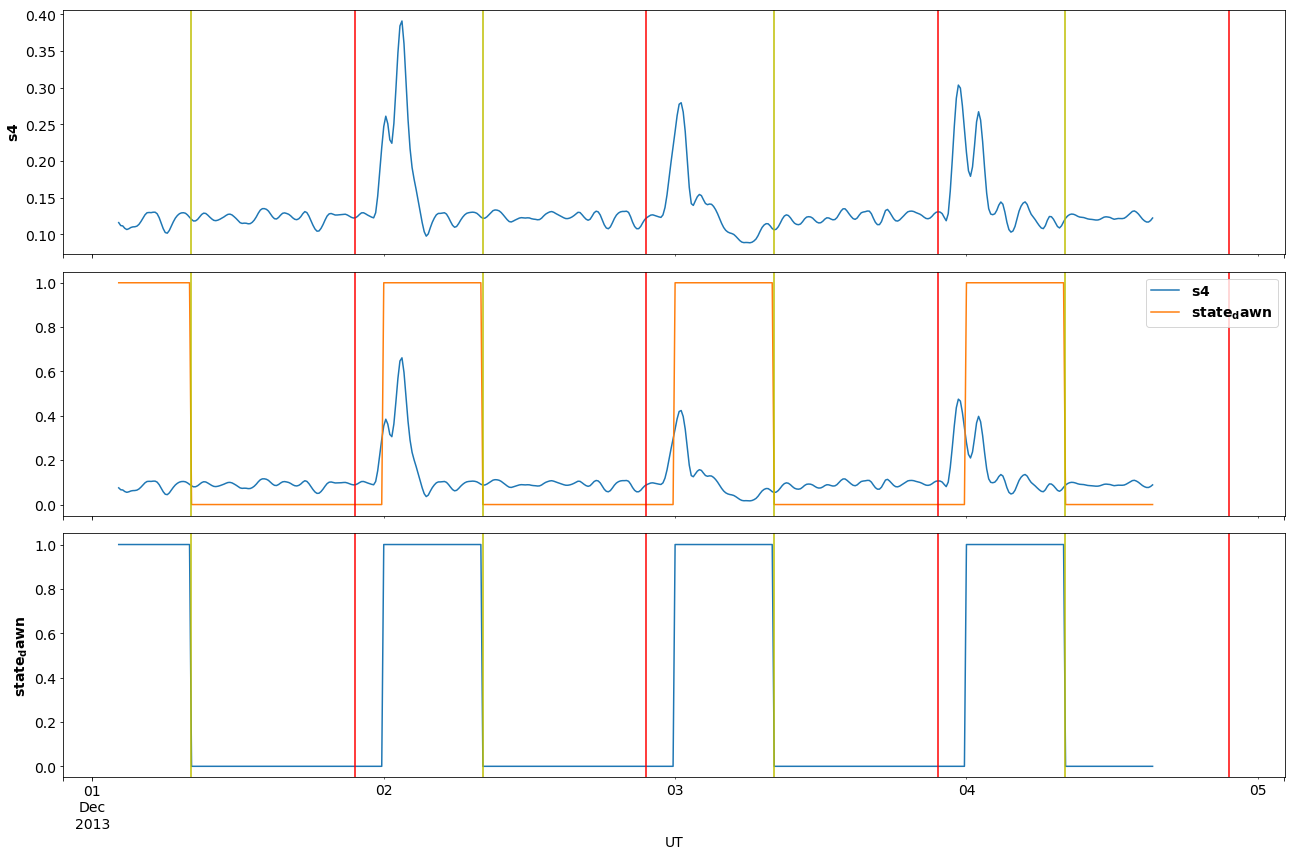

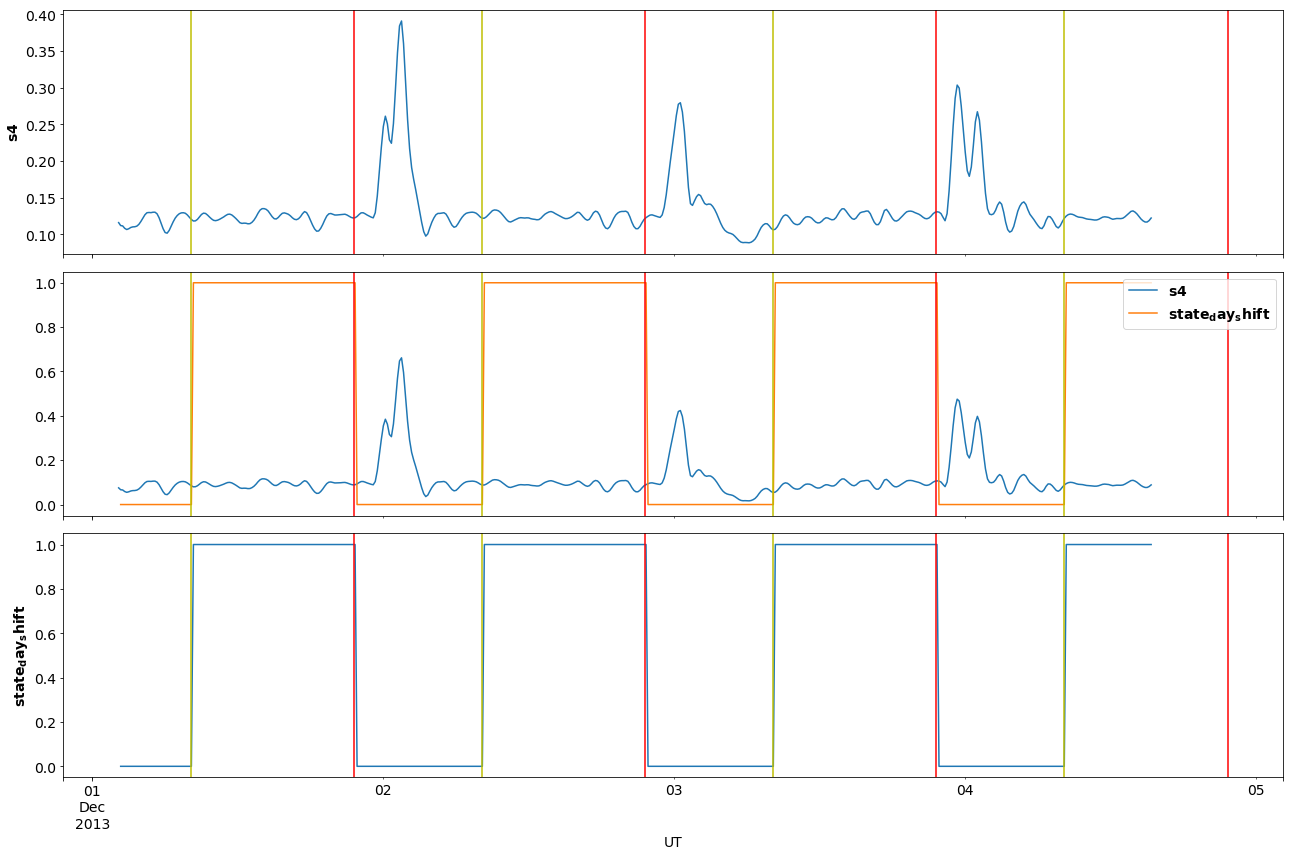

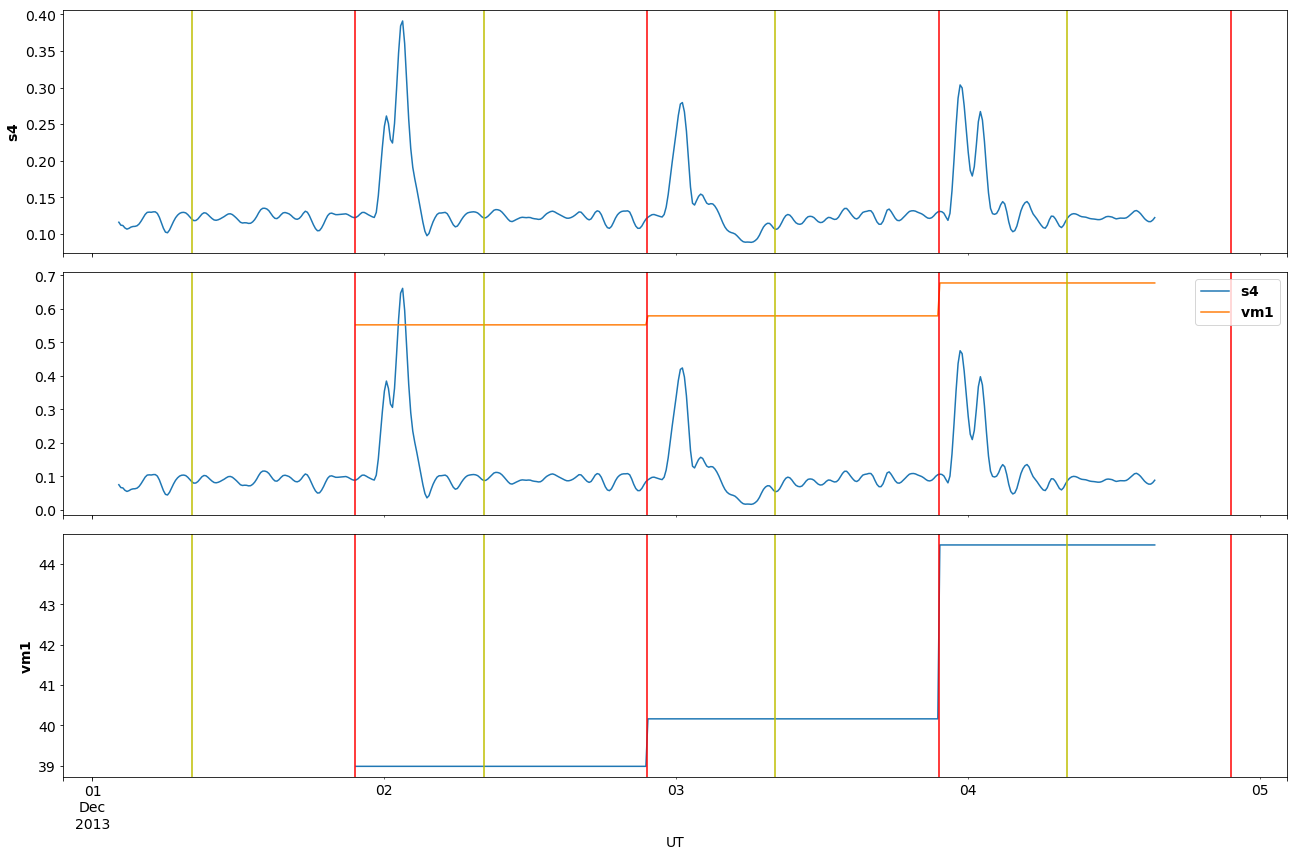

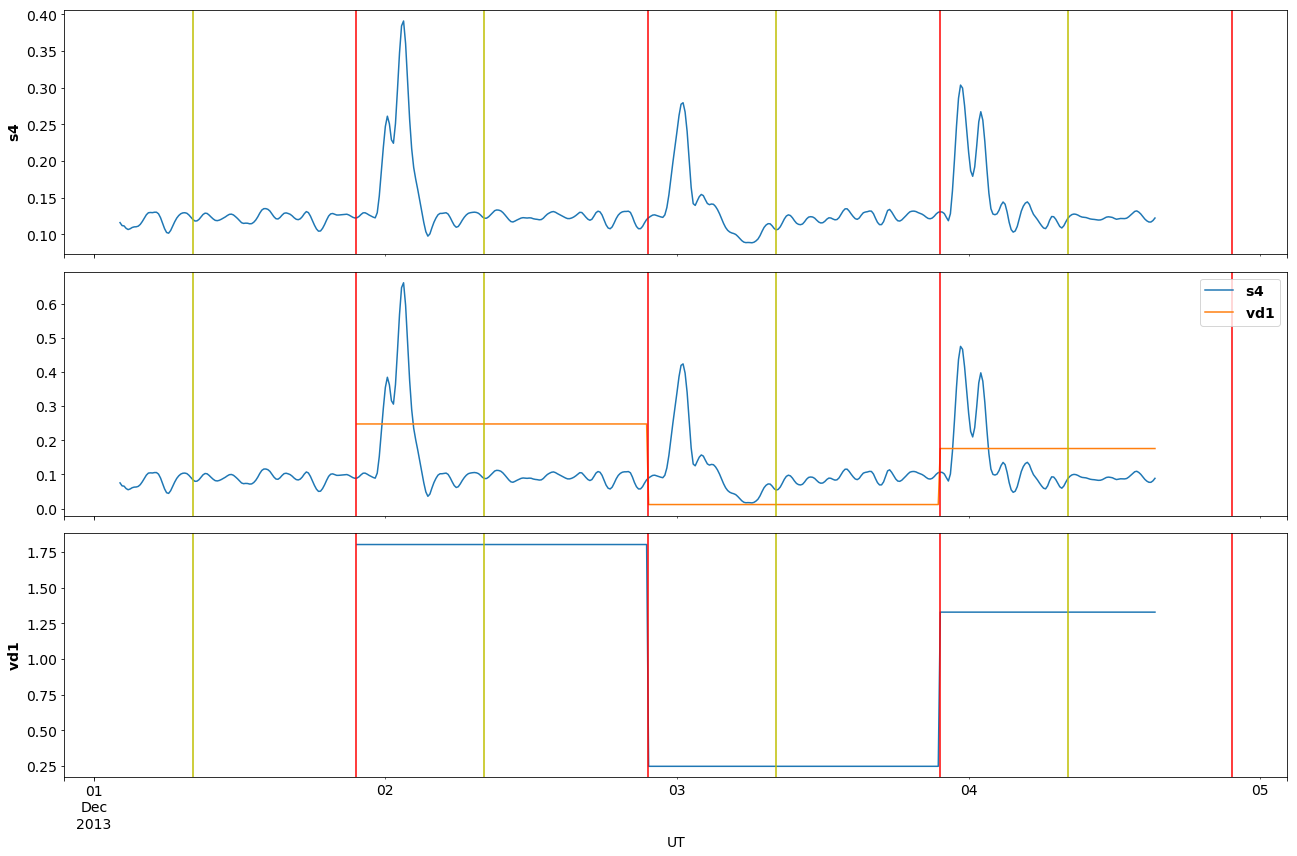

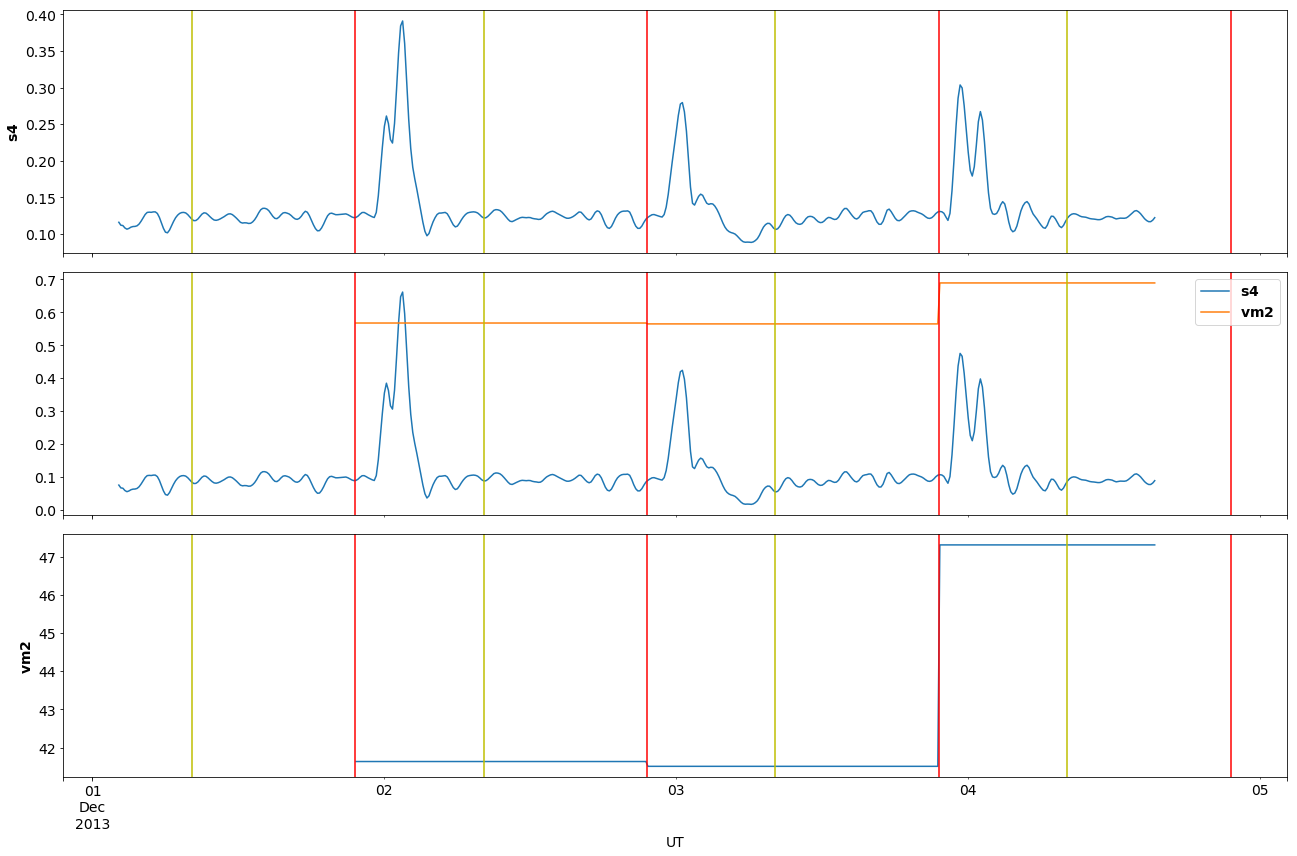

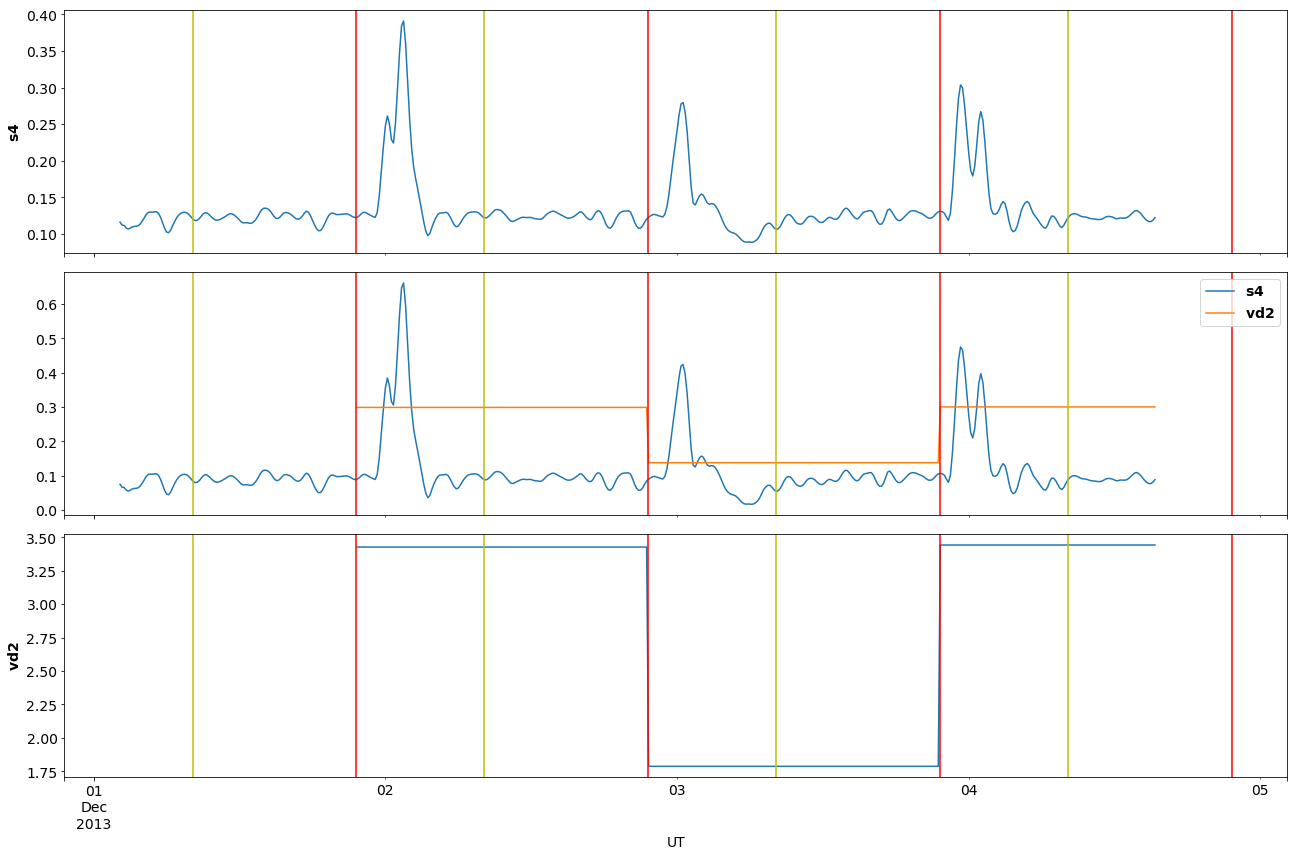

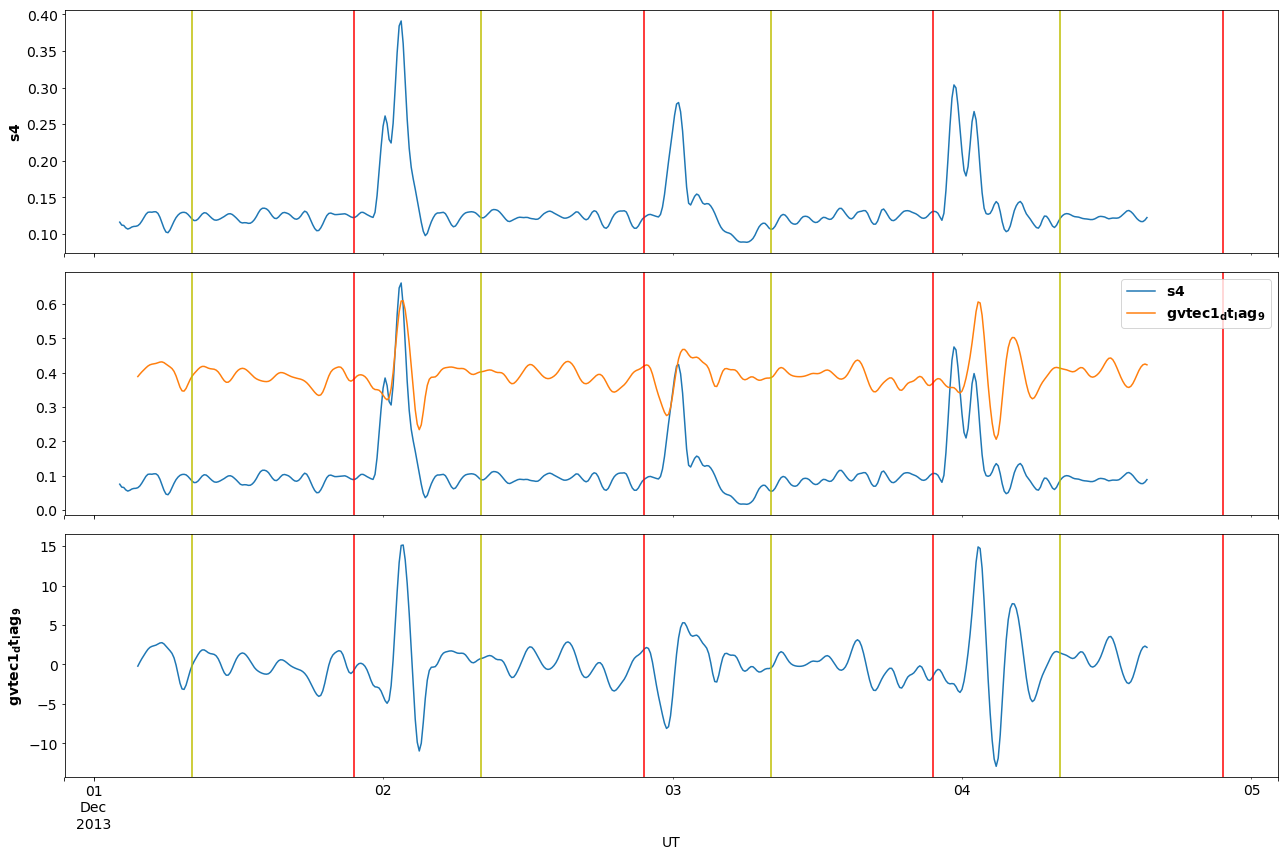

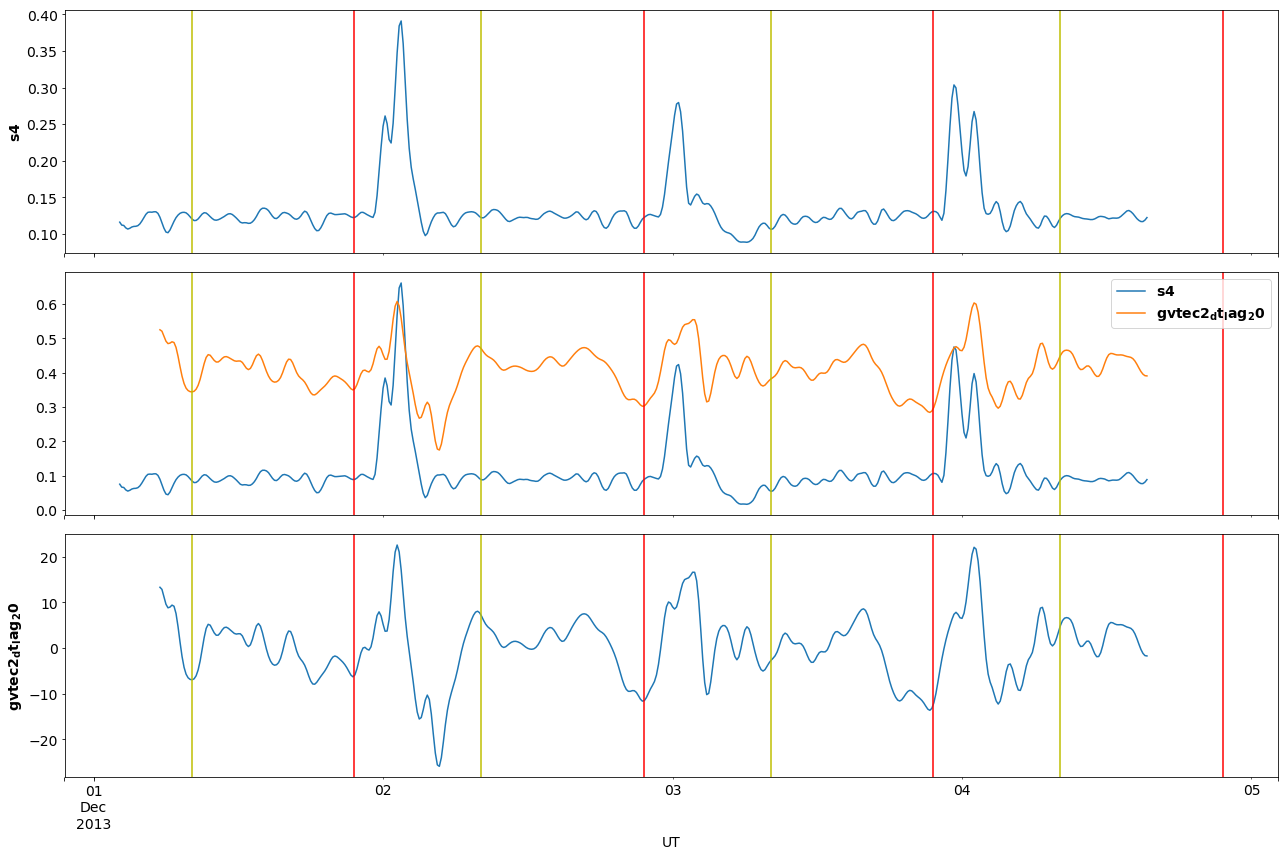

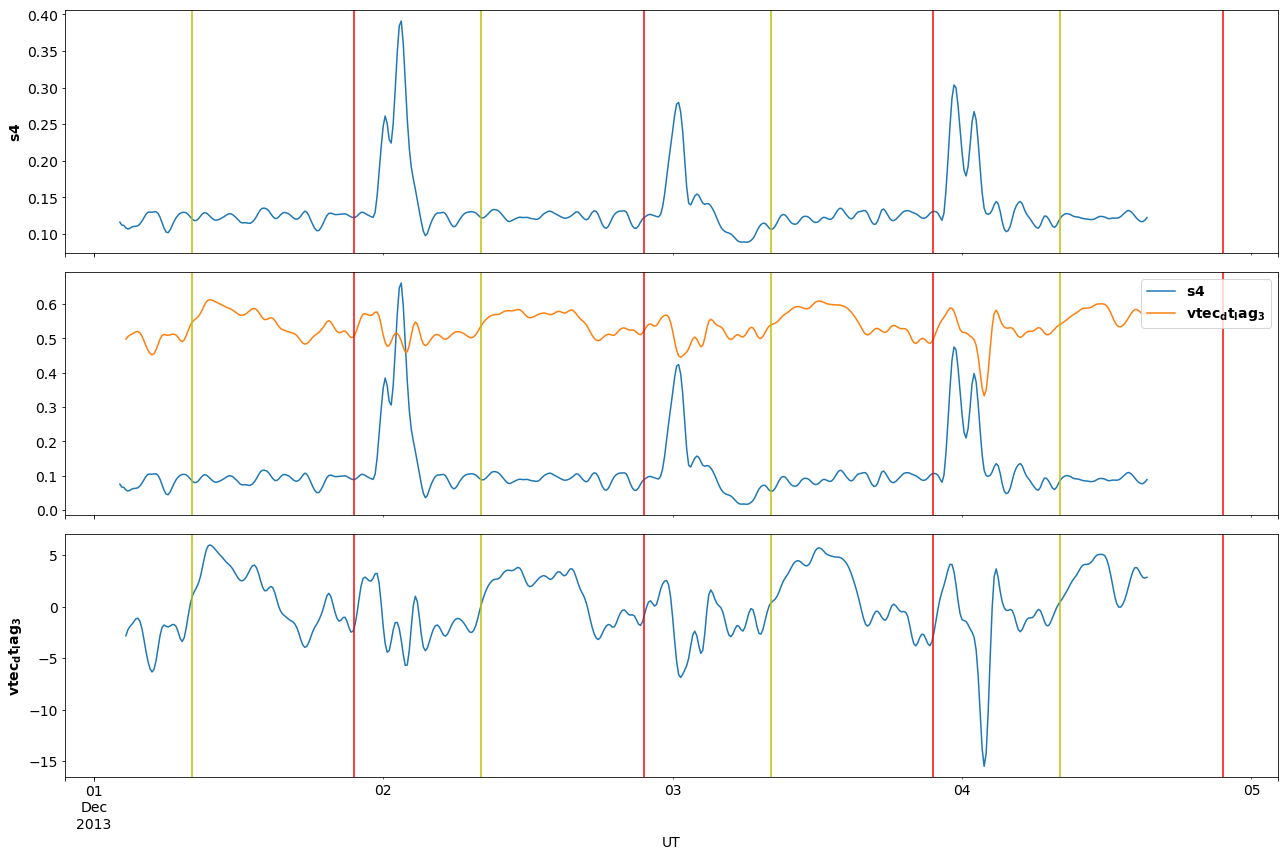

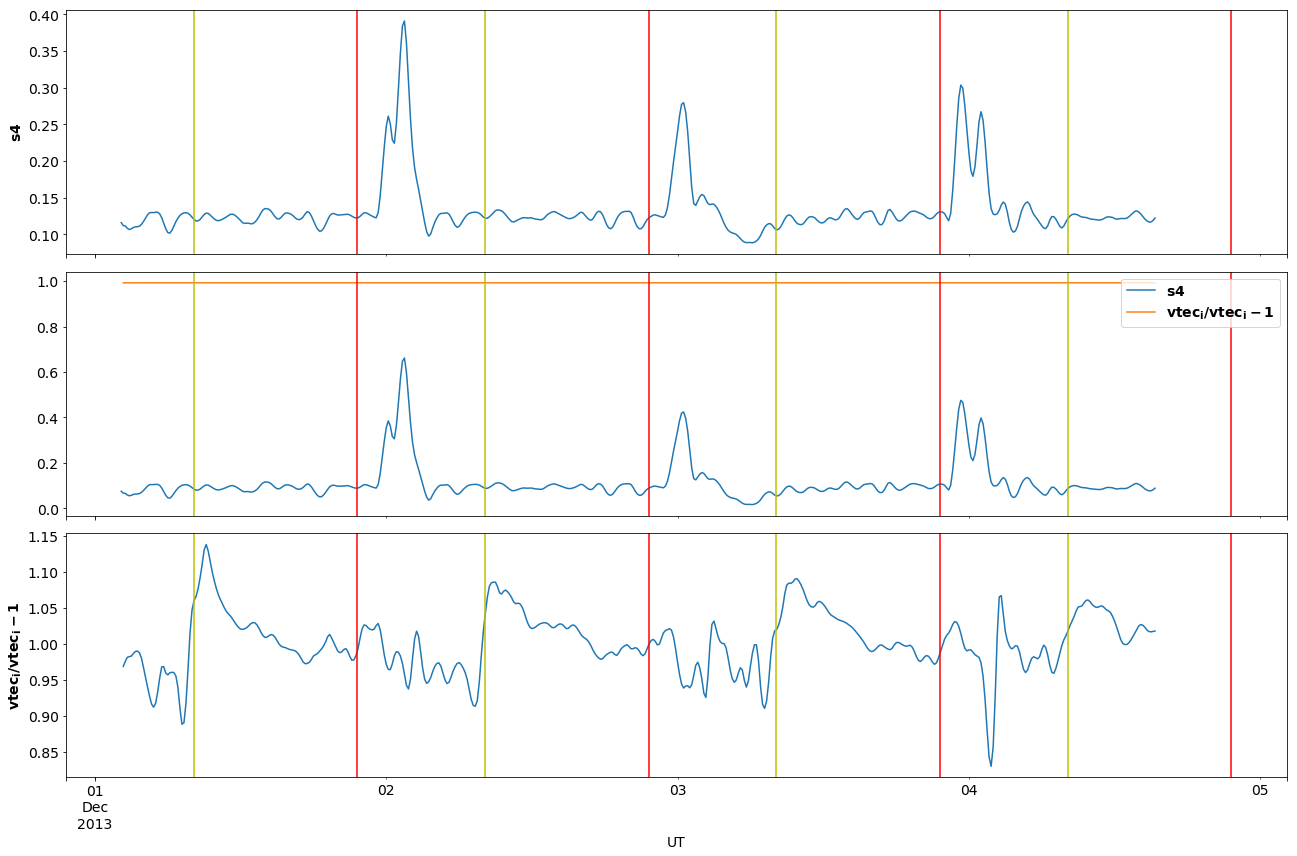

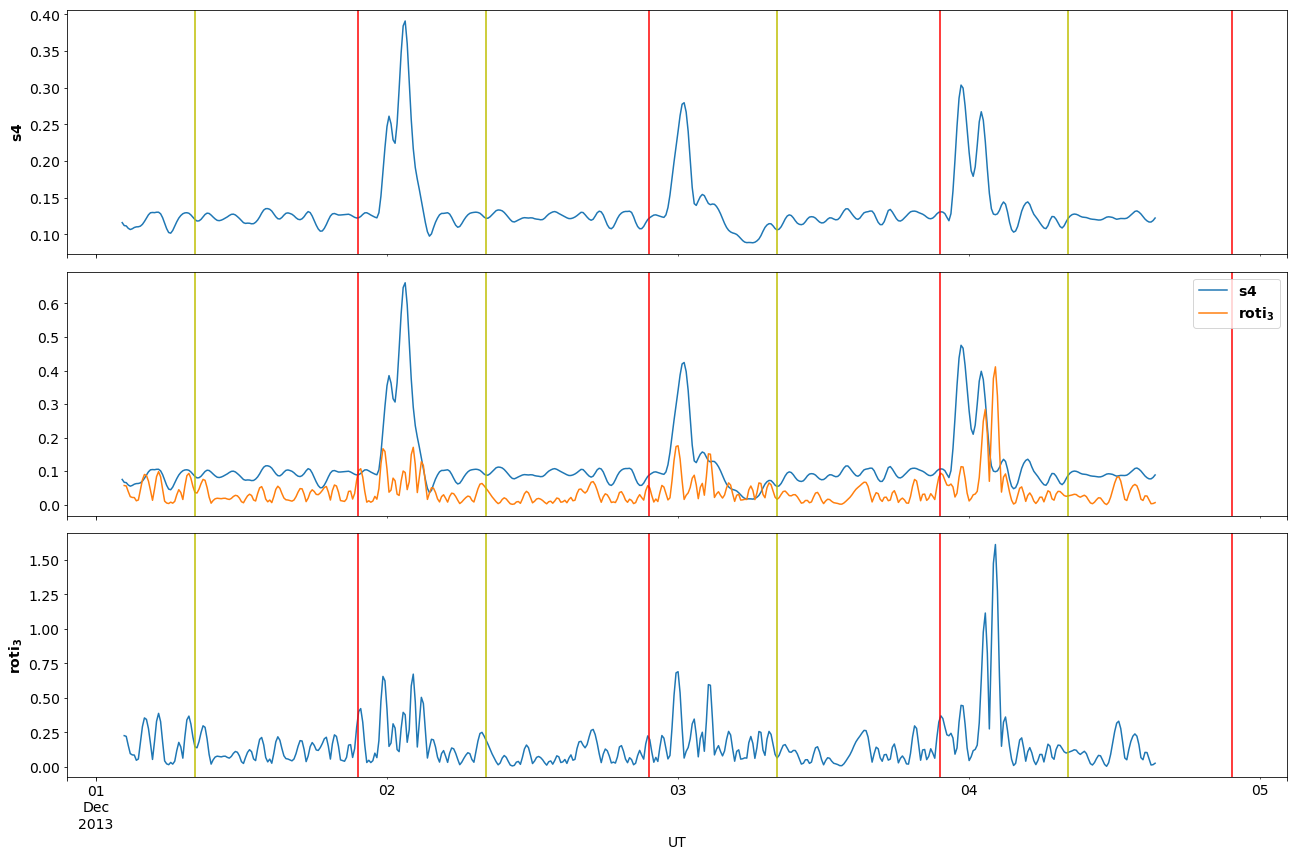

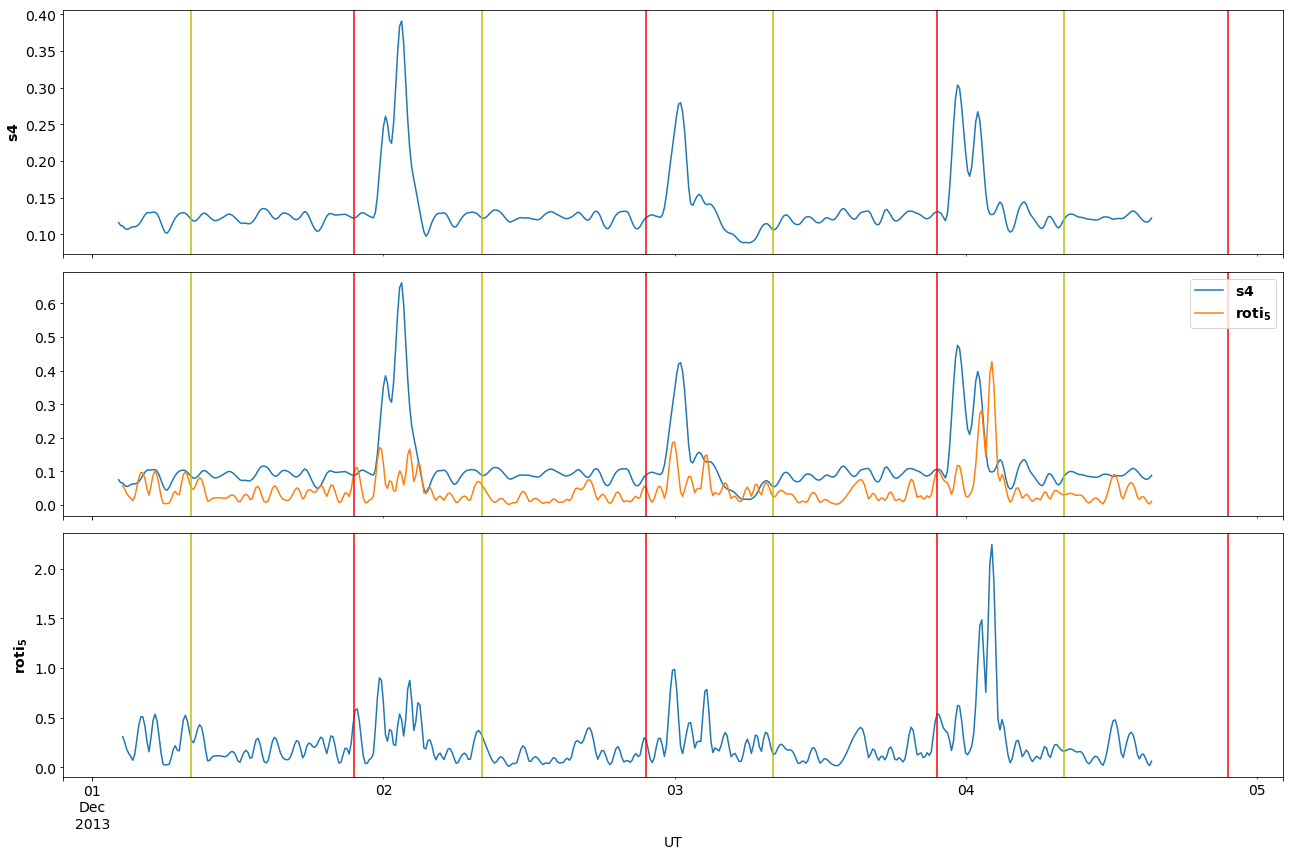

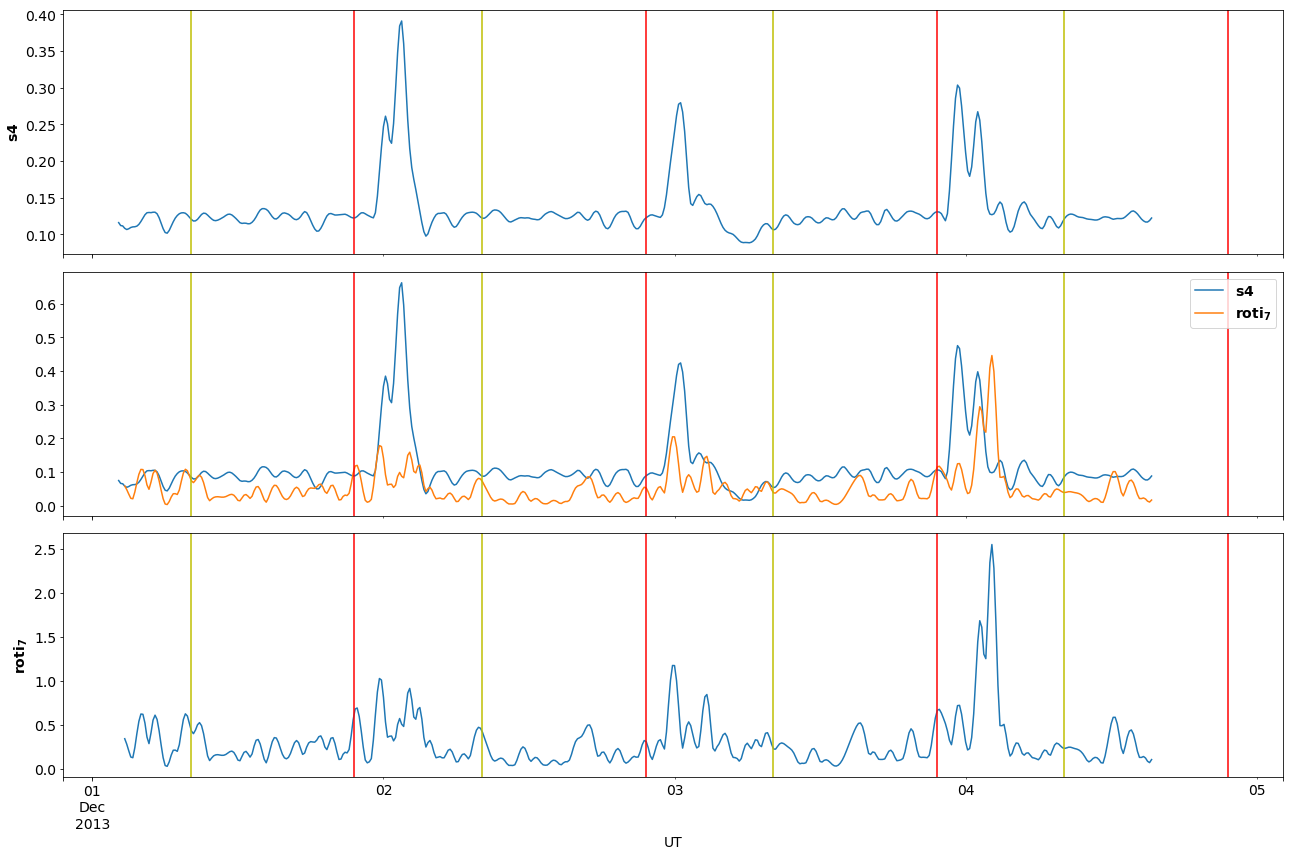

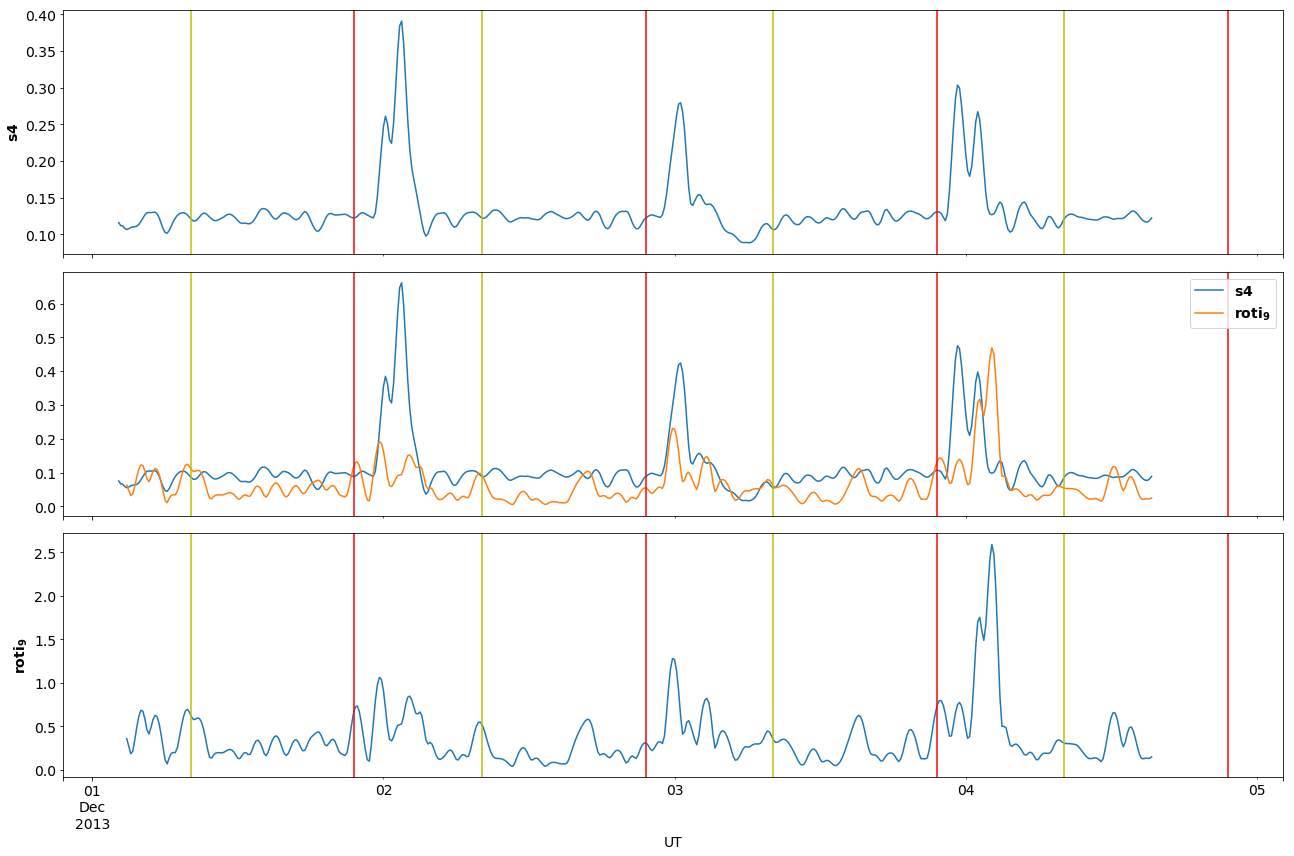

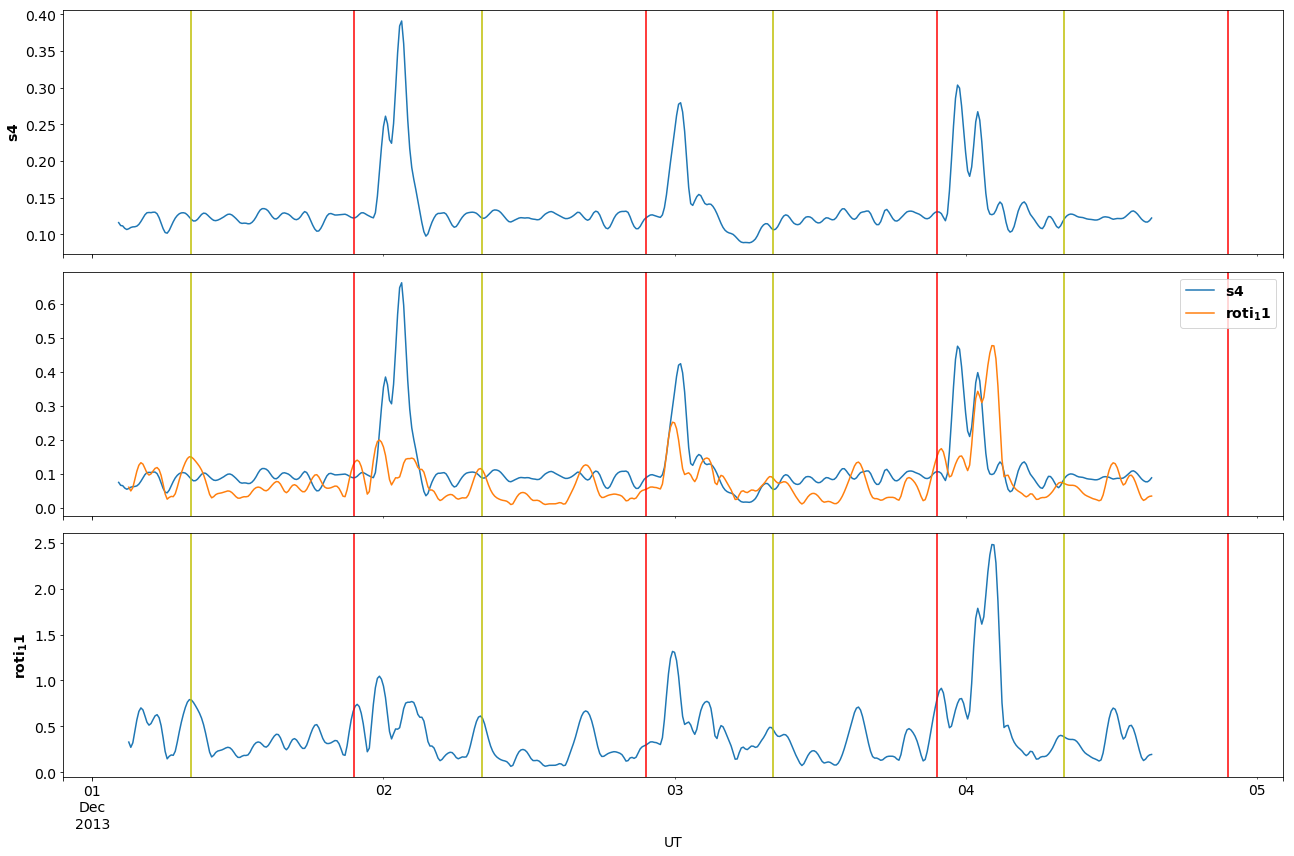

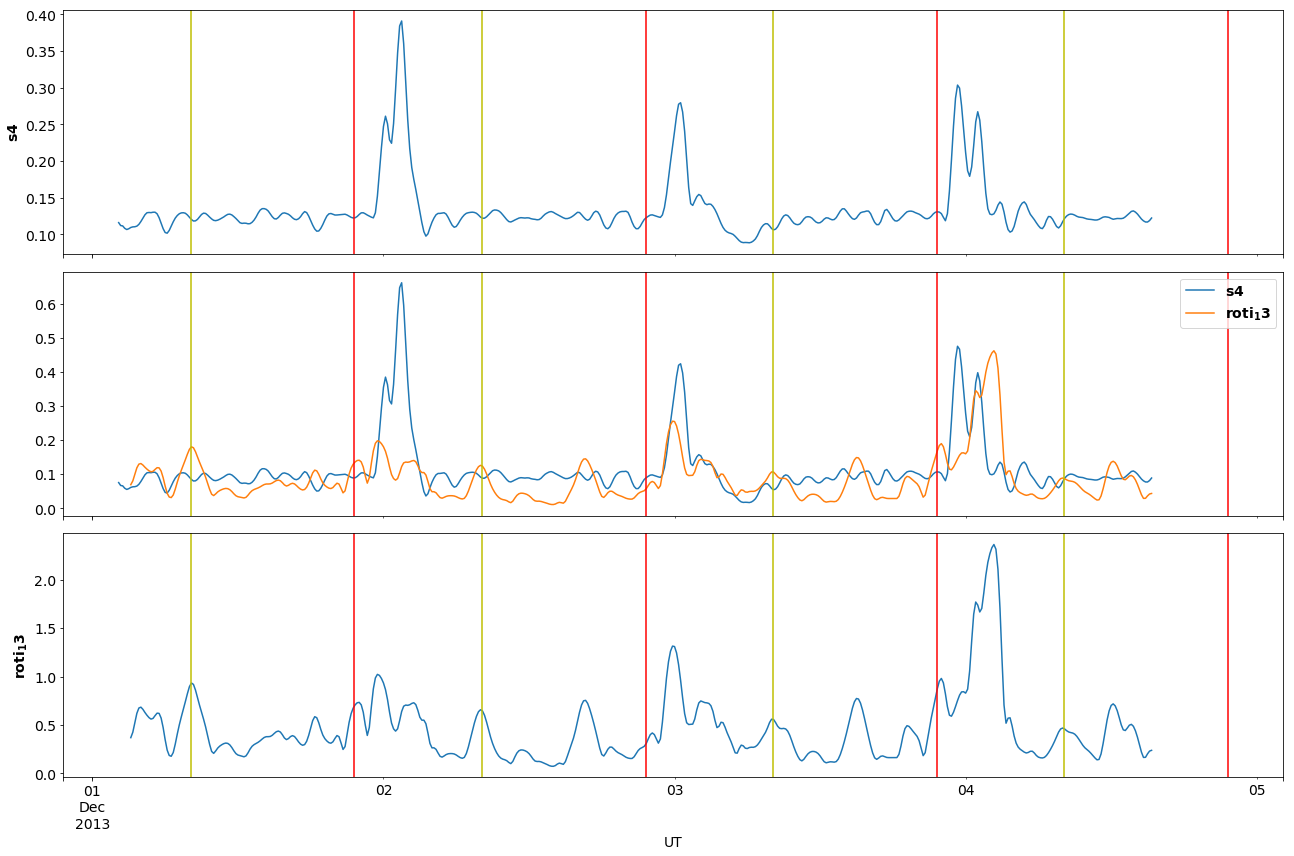

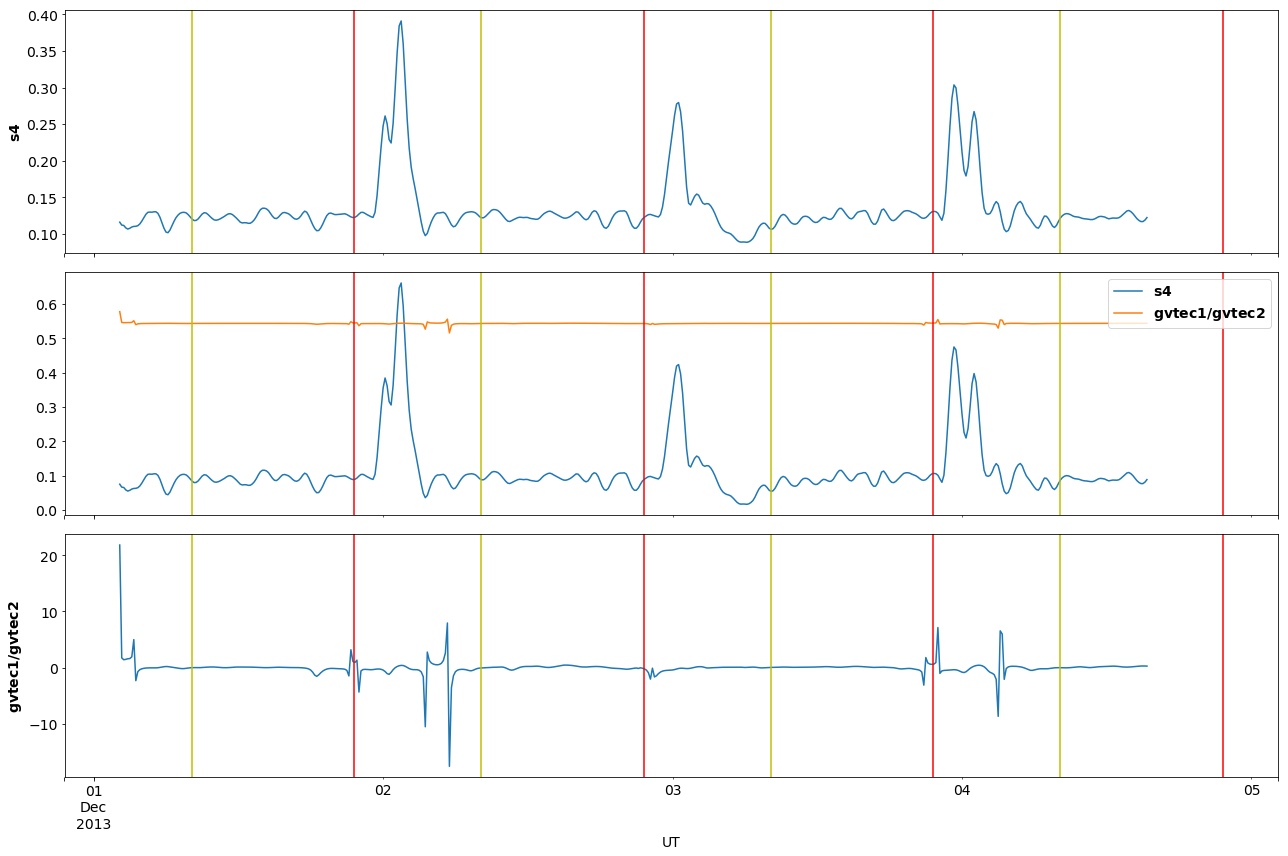

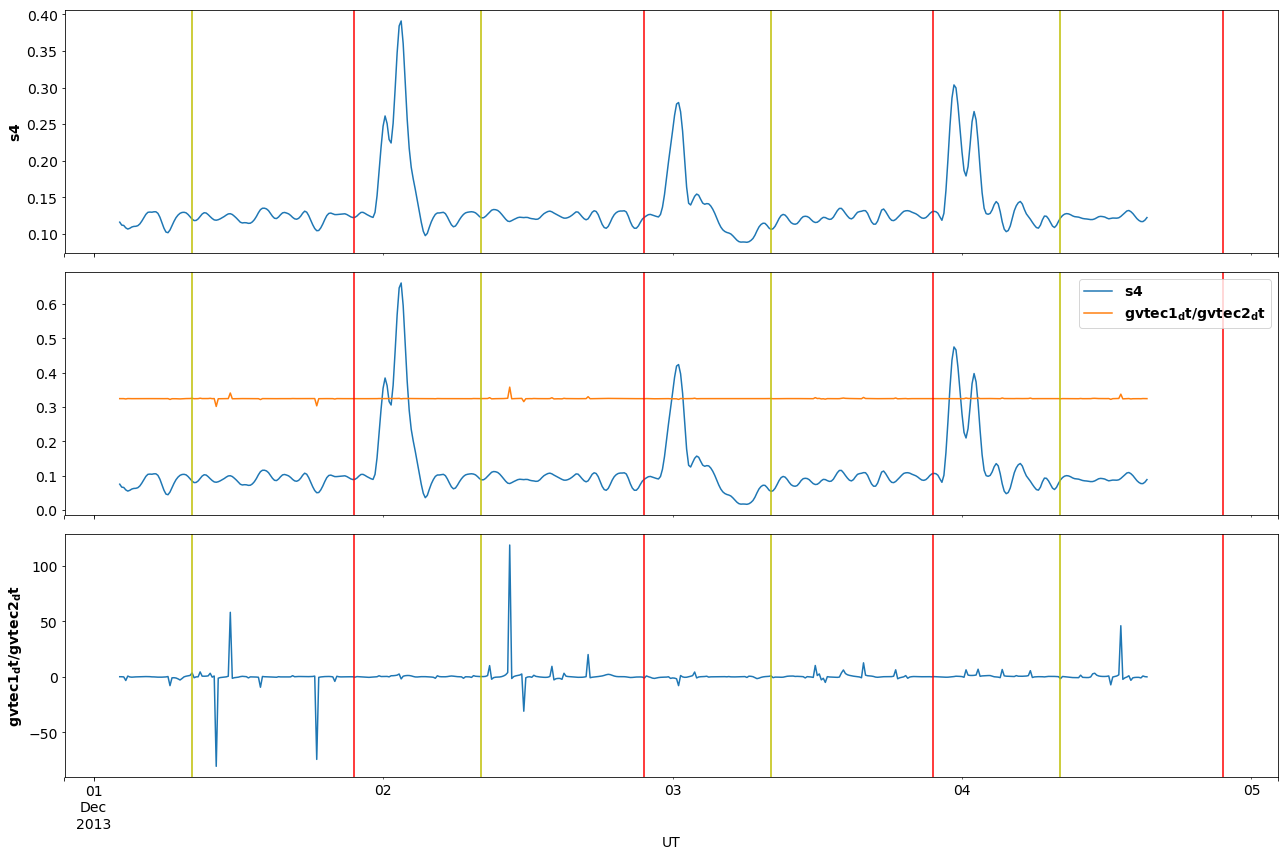

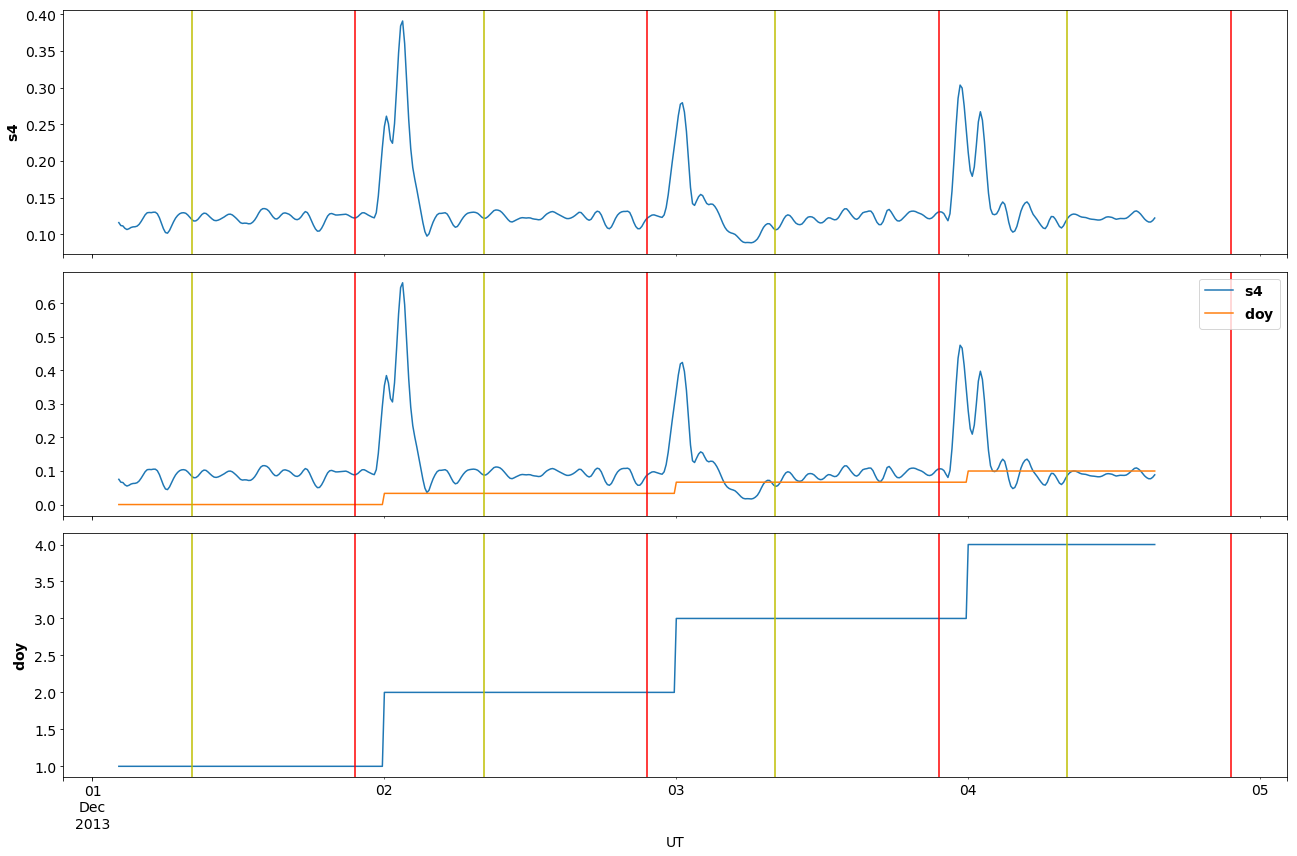

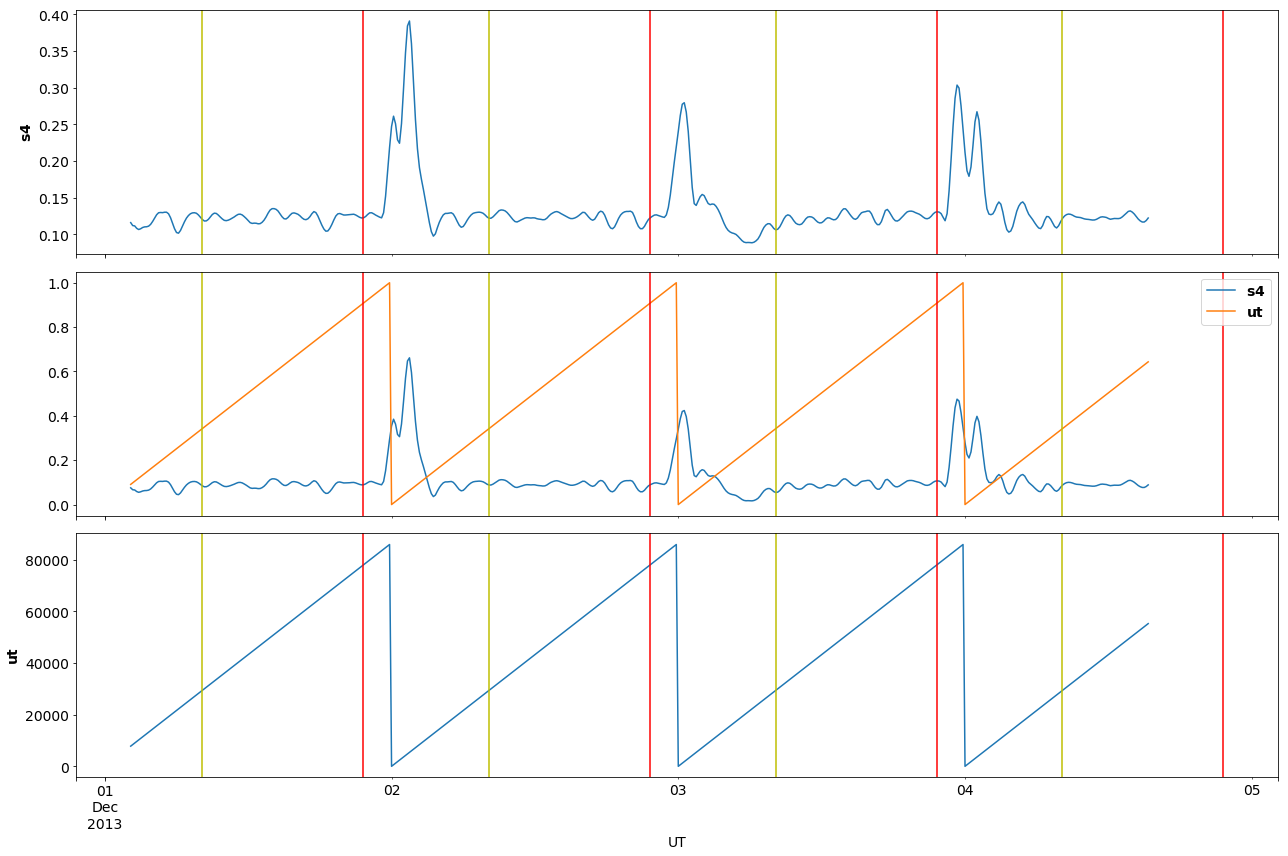

In [12]:
a = 0
b = 512

for i in df.columns:
    fig, ax = plt.subplots(3, 1, sharex=True)
    figsize=(18, 12)
    df['s4'][a:b].plot(figsize=figsize, ax=ax[0])
    df[i][a:b].plot(figsize=figsize, ax=ax[2])

    scale_first = Scale(df['s4'].min(), df['s4'].max())
    first_scale = pd.Series(scale_first(df['s4'].values), index=df.index.values)

    scale_i = Scale(df[i].min(), df[i].max())
    i_scale = pd.Series(scale_i(df[i].values), index=df.index.values)

    first_scale[a:b].plot(figsize=figsize, ax=ax[1], label=r"$\bf s4$") 
    i_scale[a:b].plot(figsize=figsize, ax=ax[1], label=r"$\bf %s$" % i)
    ax[1].legend(loc="upper right")

    ax[0].set(ylabel=r"$\bf s4$")
    ax[2].set(ylabel=r"$\bf %s$" % i)
    ax[2].set(xlabel=r"UT")

    plot_sunrise_and_sunset('sj2', df[a:b], ax)

    fig.tight_layout()

In [13]:
df = df.dropna()

# drop day, continue with just night
df = df[df['state_day'] == 0.0]
if 'state_day' in df.columns.values:
    df = df.drop('state_day', axis=1)

df.to_pickle('./data/sj2_analise_update2_drop.pkl')
df.to_csv('./data/sj2_analise_update2_drop.csv')

In [14]:
X = df[['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2',
       'gvtec2_dt', 'state_night', 'state_dawn',
       'state_day_shift', 'vm1', 'vd1', 'vm2', 'vd2', 'gvtec1_dt_lag_9',
       'gvtec2_dt_lag_20', 'vtec_dt_lag_3', 'vtec_i/vtec_i-1', 'roti_3',
       'roti_5', 'roti_7', 'roti_9', 'roti_11', 'roti_13', 'gvtec1/gvtec2',
       'gvtec1_dt/gvtec2_dt', 'doy', 'ut']]
y = df['s4']

In [15]:
for i, value in zip(df.columns, f_regression(X, y)[0]):
    print(i, value)

vtec 1183.7374355156862
vtec_dt 0.6648072865420545
vtec_dt2 50.22491791176315
gvtec1 438.1771028279142
gvtec1_dt 55.62511923186912
gvtec2 11.735183857601127
gvtec2_dt 26.613261450660232
gvtec3 35.903376930216616
gvtec3_dt 35.90337693021729
s4 9.261749212981035
state_night 156.89255805909386
state_dawn 43.20998557121251
state_day_shift 184.70470650116312
vm1 1.6253673287961596
vd1 1.5583002056676396
vm2 1.351488778440517
vd2 2.7743079367210712
gvtec1_dt_lag_9 2.3154185655232045
gvtec2_dt_lag_20 1304.4854831455498
vtec_dt_lag_3 1465.7115053093871
vtec_i/vtec_i-1 1539.3431392573773
roti_3 1529.2358810700296
roti_5 1466.5217339406101
roti_7 1392.438171885485
roti_9 0.21300089945378348
roti_11 0.3179833321521499
roti_13 18.4357352606382
gvtec1/gvtec2 13.085554076354002


In [16]:
for i, value in zip(df.columns, mutual_info_regression(X, y)):
    print(i, value)

vtec 0.2485435586233251
vtec_dt 0.07862280125629884
vtec_dt2 0.08473370214342602
gvtec1 0.08249332522742314
gvtec1_dt 0.07504432269013783
gvtec2 0.09552668760330185
gvtec2_dt 0.08653781436153096
gvtec3 0.03732455545587299
gvtec3_dt 0.03732455545587299
s4 0.011562356457037515
state_night 0.29361945824497226
state_dawn 0.30224642630738163
state_day_shift 0.3094672741478668
vm1 0.306251303333295
vd1 0.08358549723477005
vm2 0.0734928860877897
vd2 0.06051854726247363
gvtec1_dt_lag_9 0.0782641460382516
gvtec2_dt_lag_20 0.08939869055222172
vtec_dt_lag_3 0.10090815012631715
vtec_i/vtec_i-1 0.11259154194670362
roti_3 0.13089349400855532
roti_5 0.10802683406170033
roti_7 0.1256719337170198
roti_9 0.051169353335084544
roti_11 0.009967629569627157
roti_13 0.19874742074038831
gvtec1/gvtec2 0.3578328466735723


In [17]:
clf = ExtraTreesRegressor(n_estimators=50)
clf = clf.fit(X, y)
for i, value in zip(df.columns, clf.feature_importances_):
    print(i, value)

vtec 0.09878960724282398
vtec_dt 0.012170489491523424
vtec_dt2 0.017865173886295337
gvtec1 0.030234668834622523
gvtec1_dt 0.021496690428048807
gvtec2 0.0629101186681071
gvtec2_dt 0.024691195816804366
gvtec3 0.011511386223034024
gvtec3_dt 0.013776722301829003
s4 0.00012783800616546188
state_night 0.0353456726353005
state_dawn 0.05109867644375472
state_day_shift 0.03482593637220059
vm1 0.03824351436757722
vd1 0.027102076794115103
vm2 0.059971684203606844
vd2 0.012239187047006793
gvtec1_dt_lag_9 0.009822165053711395
gvtec2_dt_lag_20 0.015867936555166308
vtec_dt_lag_3 0.03390526185822311
vtec_i/vtec_i-1 0.02214831721933536
roti_3 0.04601274813383155
roti_5 0.045576209366849696
roti_7 0.034864551542244625
roti_9 0.013651774291498865
roti_11 0.007766718772579526
roti_13 0.0641141018927657
gvtec1/gvtec2 0.153869576550978
